# **PySpark**: The Apache Spark Python API

## 1. Introduction

This notebook shows how to connect Jupyter notebooks to a Spark cluster to process data using Spark Python API.

## The Spark Cluster

### 1. Connection

To connect to the Spark cluster, create a SparkSession object with the following params:

+ **appName:** application name displayed at the [Spark Master Web UI](http://localhost:8080/);
+ **master:** Spark Master URL, same used by Spark Workers;
+ **spark.executor.memory:** must be less than or equals to docker compose SPARK_WORKER_MEMORY config.

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from dateutil.parser import parse 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randrange
from datetime import datetime, timedelta 
import glob
from statsmodels.tsa.seasonal import STL
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,DoubleType,DateType,FloatType,DecimalType
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import isnan, when, count, col, coalesce
from pyspark.sql.functions import pandas_udf,PandasUDFType
from pyspark.sql.window import Window
from pyspark.sql import functions as func
from pyspark.sql import functions as F
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model    import OLS
import itertools
import warnings
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy import fft
from scipy import signal as sig
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore')

In [2]:
path= os.path.abspath("data")

In [ ]:
import findspark

findspark.init()

In [ ]:
spark = SparkSession.builder.appName("SPARK app for SMP values").getOrCreate()

In [4]:
sc = spark.sparkContext
sqlCtx = SQLContext(sc)

## 2. Data fetch from HDFS

In [5]:
YEAR_2018_PATH = os.path.join(path,"2018_DAS")
all_2018_files = glob.glob(YEAR_2018_PATH + "/*.xls")
YEAR_2019_PATH = os.path.join(path,"2019_DAS")
all_2019_files = glob.glob(YEAR_2019_PATH + "/*.xls")
YEAR_2020_PATH = os.path.join(path,"2020_DAS")
all_2020_files = glob.glob(YEAR_2020_PATH + "/*.xls")

In [6]:
schema = StructType([
  StructField('SMPS', DoubleType(), True),
    StructField('Daily_Average_SMP', DoubleType(), True), 
  StructField('date', DateType(), True)
  ])

In [7]:
year_2018_df = spark.createDataFrame([], schema)
year_2019_df = spark.createDataFrame([], schema)
year_2020_df = spark.createDataFrame([], schema)

Extract smps and dates from excel files from RAE

In [8]:
for filename in sorted(all_2018_files):
    df = pd.read_excel(filename,sheet_name=0,skiprows=[0])
    res = re.findall("(\d+)", filename)[1]
    Hours = datetime.strptime(res, '%Y%m%d')
    date_rng = pd.date_range(start=(Hours+timedelta(hours = 0)), end=(Hours+timedelta(hours = 23)), freq='H')
#date_rng.values
    SMP_values=df.iloc[4,1:25]
    mylist= [df.iloc[4,26]]*24
    hour_smp_collection = pd.DataFrame({'SMPS': SMP_values.tolist(),'Daily_Average_SMP':mylist, 'date':date_rng})
    spark_df= spark.createDataFrame(hour_smp_collection)
    year_2018_df= year_2018_df.union(spark_df)
   


In [9]:
for filename in sorted(all_2019_files):
    df = pd.read_excel(filename,sheet_name=0,skiprows=[0])
    res = re.findall("(\d+)", filename)[1]
    Hours = datetime.strptime(res, '%Y%m%d')
    date_rng = pd.date_range(start=(Hours+timedelta(hours = 0)), end=(Hours+timedelta(hours = 23)), freq='H')
#date_rng.values
    SMP_values=df.iloc[4,1:25]
    mylist= [df.iloc[4,26]]*24
    hour_smp_collection = pd.DataFrame({'SMPS': SMP_values.tolist(),'Daily_Average_SMP':mylist, 'date':date_rng})
    spark_df= spark.createDataFrame(hour_smp_collection) 
    year_2019_df= year_2019_df.union(spark_df)


In [10]:
for filename in sorted(all_2020_files):
    df = pd.read_excel(filename,sheet_name=0,skiprows=[0])
    res = re.findall("(\d+)", filename)[1]
    Hours = datetime.strptime(res, '%Y%m%d')
    date_rng = pd.date_range(start=(Hours+timedelta(hours = 0)), end=(Hours+timedelta(hours = 23)), freq='H')
    SMP_values=df.iloc[4,1:25]
    mylist= [df.iloc[4,26]]*24
    hour_smp_collection = pd.DataFrame({'SMPS': SMP_values.tolist(),'Daily_Average_SMP':mylist, 'date':date_rng}) 
    spark_df= spark.createDataFrame(hour_smp_collection)
    year_2020_df= year_2020_df.union(spark_df)


Merge data from 2018-2020

In [11]:
dfs = [year_2018_df, year_2019_df, year_2020_df]

# create merged dataframe
final_df = reduce(DataFrame.unionAll, dfs)

final_df.show()

+------+-----------------+-------------------+
|  SMPS|Daily_Average_SMP|               date|
+------+-----------------+-------------------+
|57.883|52.85216666666667|2018-01-01 00:00:00|
|58.088|52.85216666666667|2018-01-01 01:00:00|
|57.959|52.85216666666667|2018-01-01 02:00:00|
|54.575|52.85216666666667|2018-01-01 03:00:00|
| 54.47|52.85216666666667|2018-01-01 04:00:00|
|54.848|52.85216666666667|2018-01-01 05:00:00|
|54.852|52.85216666666667|2018-01-01 06:00:00|
|53.783|52.85216666666667|2018-01-01 07:00:00|
| 52.57|52.85216666666667|2018-01-01 08:00:00|
|  42.8|52.85216666666667|2018-01-01 09:00:00|
|50.178|52.85216666666667|2018-01-01 10:00:00|
|50.646|52.85216666666667|2018-01-01 11:00:00|
|50.642|52.85216666666667|2018-01-01 12:00:00|
|52.834|52.85216666666667|2018-01-01 13:00:00|
|51.169|52.85216666666667|2018-01-01 14:00:00|
|52.877|52.85216666666667|2018-01-01 15:00:00|
|51.871|52.85216666666667|2018-01-01 16:00:00|
|52.932|52.85216666666667|2018-01-01 17:00:00|
|51.265|52.85

In [12]:
final_df.persist()

DataFrame[SMPS: double, Daily_Average_SMP: double, date: timestamp]

In [12]:
final_df.count()

24888

In [63]:
final_df.printSchema()

root
 |-- SMPS: double (nullable = true)
 |-- Daily_Average_SMP: double (nullable = true)
 |-- date: timestamp (nullable = true)



In [61]:
final_df.describe()

DataFrame[summary: string, SMPS: string, Daily_Average_SMP: string]

Check for Nan Values.It is anticipated to have such values only in SMPS column

In [20]:

final_df.where(isnan(col("SMPS"))).show(50)


+----+-----------------+-------------------+
|SMPS|Daily_Average_SMP|               date|
+----+-----------------+-------------------+
| NaN|36.55230434782609|2018-03-25 23:00:00|
| NaN|53.08413043478261|2019-03-31 23:00:00|
| NaN|38.19165217391305|2020-03-29 23:00:00|
| NaN|           92.223|2020-11-01 01:00:00|
| NaN|           92.223|2020-11-01 02:00:00|
| NaN|           92.223|2020-11-01 03:00:00|
| NaN|           92.223|2020-11-01 04:00:00|
| NaN|           92.223|2020-11-01 05:00:00|
| NaN|           92.223|2020-11-01 06:00:00|
| NaN|           92.223|2020-11-01 07:00:00|
| NaN|           92.223|2020-11-01 08:00:00|
| NaN|           92.223|2020-11-01 09:00:00|
| NaN|           92.223|2020-11-01 10:00:00|
| NaN|           92.223|2020-11-01 11:00:00|
| NaN|           92.223|2020-11-01 12:00:00|
| NaN|           92.223|2020-11-01 13:00:00|
| NaN|           92.223|2020-11-01 14:00:00|
| NaN|           92.223|2020-11-01 15:00:00|
| NaN|           92.223|2020-11-01 16:00:00|
| NaN|    

We replace Nan values with nulls so as to use coalesce and replace them with the corresponding average value

In [13]:
final_df = final_df.replace(float('nan'), None)
total_final=final_df.withColumn('SMPS', coalesce('SMPS', 'Daily_Average_SMP'))

total_final.show()

+------+-----------------+-------------------+
|  SMPS|Daily_Average_SMP|               date|
+------+-----------------+-------------------+
|57.883|52.85216666666667|2018-01-01 00:00:00|
|58.088|52.85216666666667|2018-01-01 01:00:00|
|57.959|52.85216666666667|2018-01-01 02:00:00|
|54.575|52.85216666666667|2018-01-01 03:00:00|
| 54.47|52.85216666666667|2018-01-01 04:00:00|
|54.848|52.85216666666667|2018-01-01 05:00:00|
|54.852|52.85216666666667|2018-01-01 06:00:00|
|53.783|52.85216666666667|2018-01-01 07:00:00|
| 52.57|52.85216666666667|2018-01-01 08:00:00|
|  42.8|52.85216666666667|2018-01-01 09:00:00|
|50.178|52.85216666666667|2018-01-01 10:00:00|
|50.646|52.85216666666667|2018-01-01 11:00:00|
|50.642|52.85216666666667|2018-01-01 12:00:00|
|52.834|52.85216666666667|2018-01-01 13:00:00|
|51.169|52.85216666666667|2018-01-01 14:00:00|
|52.877|52.85216666666667|2018-01-01 15:00:00|
|51.871|52.85216666666667|2018-01-01 16:00:00|
|52.932|52.85216666666667|2018-01-01 17:00:00|
|51.265|52.85

In [28]:
total_final.where(isnan(col("SMPS"))).show()

+----+-----------------+----+
|SMPS|Daily_Average_SMP|date|
+----+-----------------+----+
+----+-----------------+----+



## 3. Time series model 

We can now  visualize our time series model

In [14]:
full_df = total_final.toPandas()

In [15]:
full_df.set_index("date", inplace=True)

In [16]:
len(full_df['SMPS'])

24888

method to initialize datasets.We use first two years data for training and the third for testing.

In [16]:
def initialize_datasets(dataframe):
    c= datetime(2020, 1, 1, 0, 0)

    first_two_years= dataframe[dataframe.index < c]
    first_two_years_series = np.array(first_two_years.SMPS)
    third_year = dataframe[dataframe.index > c]
    third_year_series = np.array(third_year.SMPS)
    return first_two_years,first_two_years_series,third_year,third_year_series

In [17]:
first_two_years,first_two_years_series,third_year,third_year_series =initialize_datasets(full_df)

<AxesSubplot:title={'center':'Hourly values of SMPS at 2018-2020'}, xlabel='date'>

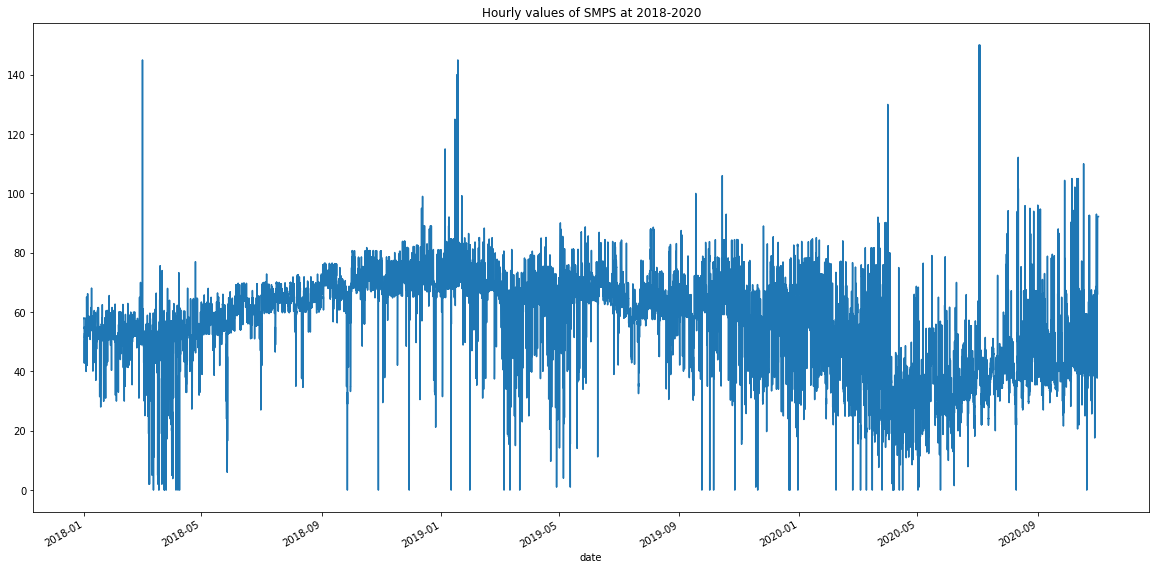

In [20]:
full_df.SMPS.plot.line(x="date", y="SMPS",figsize=(20,10),title='Hourly values of SMPS at 2018-2020')


Check timeseries data for statioanrity

In [27]:
Dickey_Fuller_Test(full_df["SMPS"].values)

ADF Statistic: -5.869317
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


create first two year training dataset

<AxesSubplot:title={'center':'Hourly values of SMPS at 2018-2019'}, xlabel='date'>

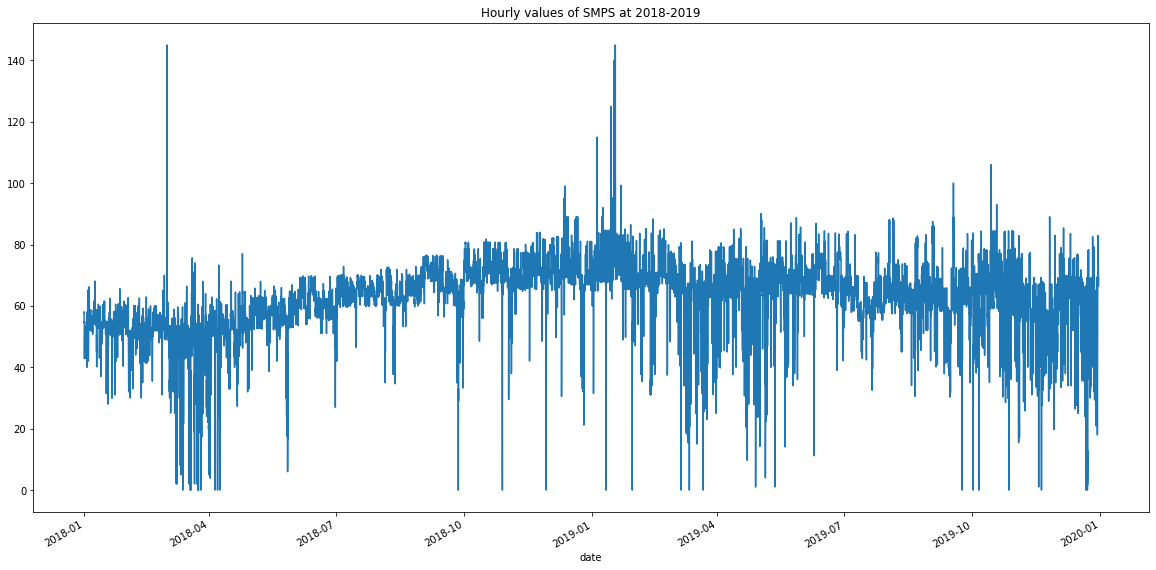

In [25]:
first_two_years.SMPS.plot.line(x="date", y="SMPS",figsize=(20,10),title='Hourly values of SMPS at 2018-2019')

In [26]:
Dickey_Fuller_Test(first_two_years["SMPS"].values)

ADF Statistic: -7.719552
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


create third year training dataset 

In [23]:
len(third_year)

7343

Autocorrelation plot 

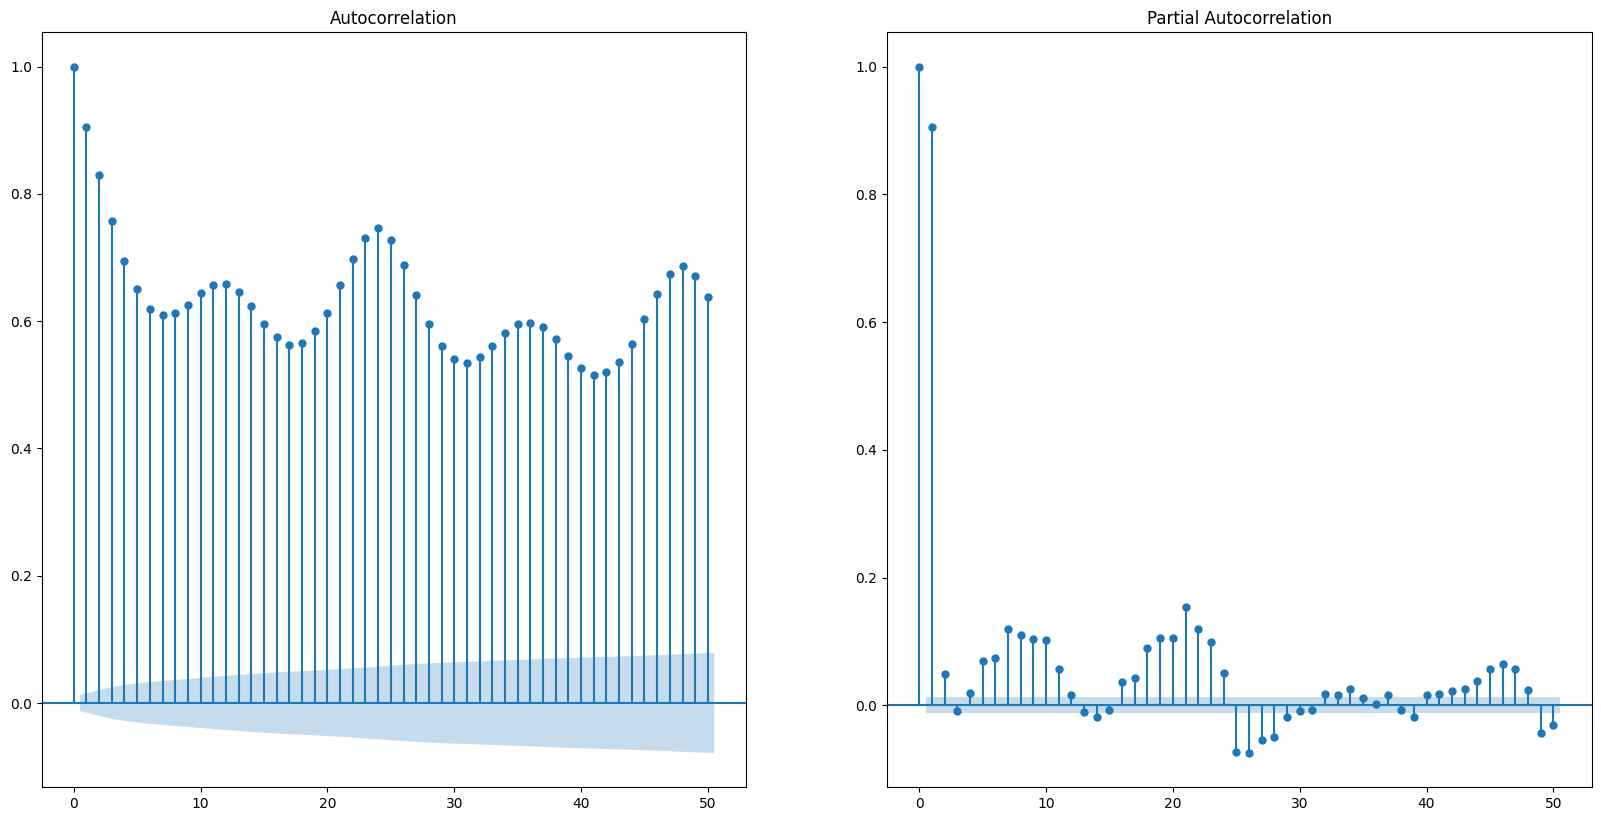

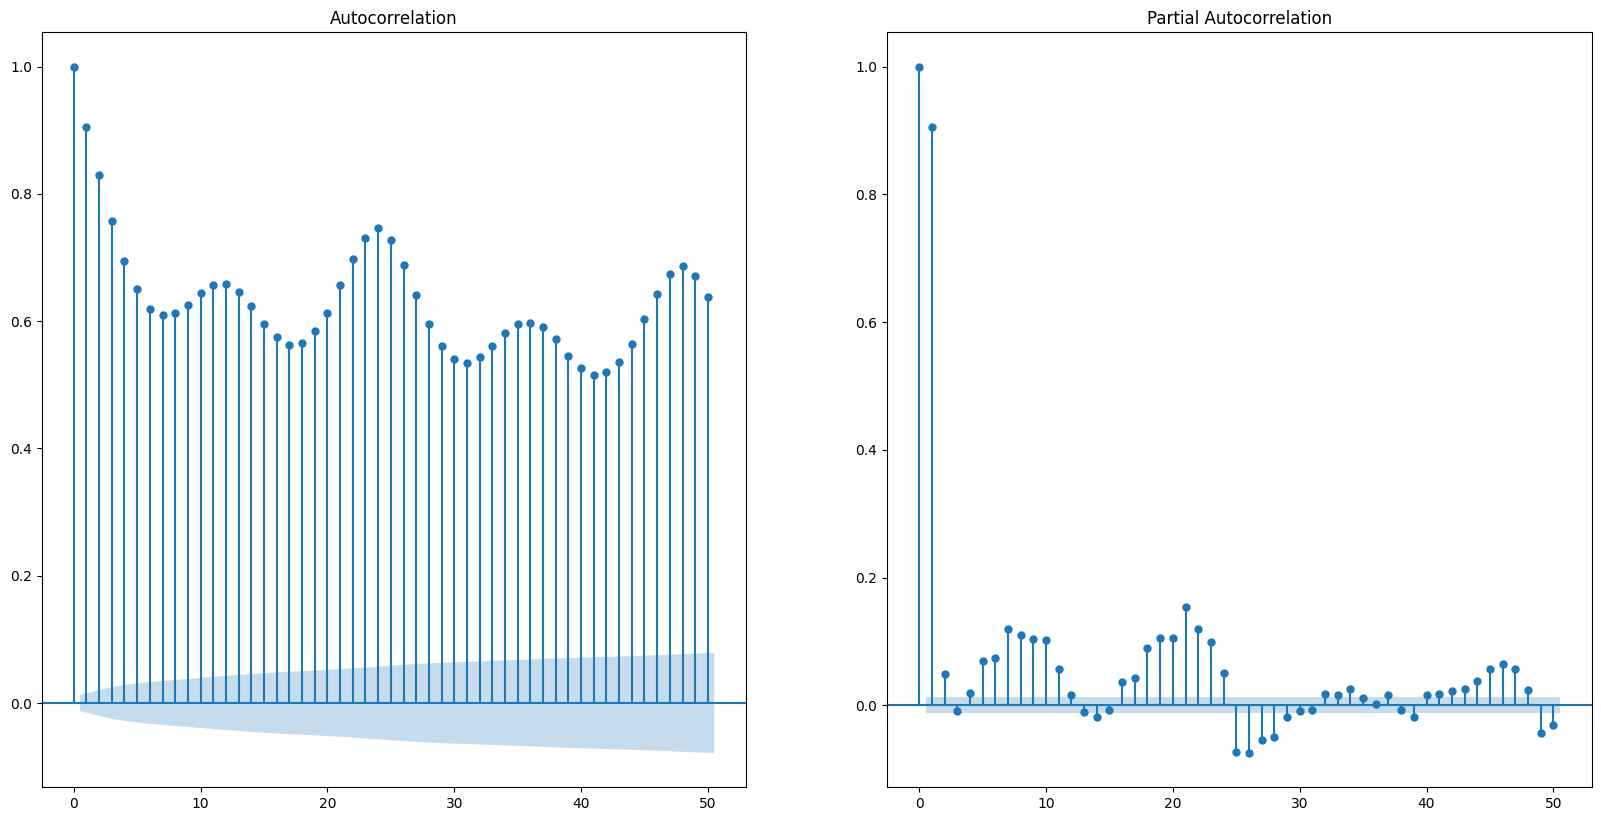

In [33]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,10), dpi= 100)
plot_acf(full_df['SMPS'].tolist(), lags= 50, ax=axes[0])
plot_pacf(full_df['SMPS'].tolist(), lags=50, ax=axes[1])


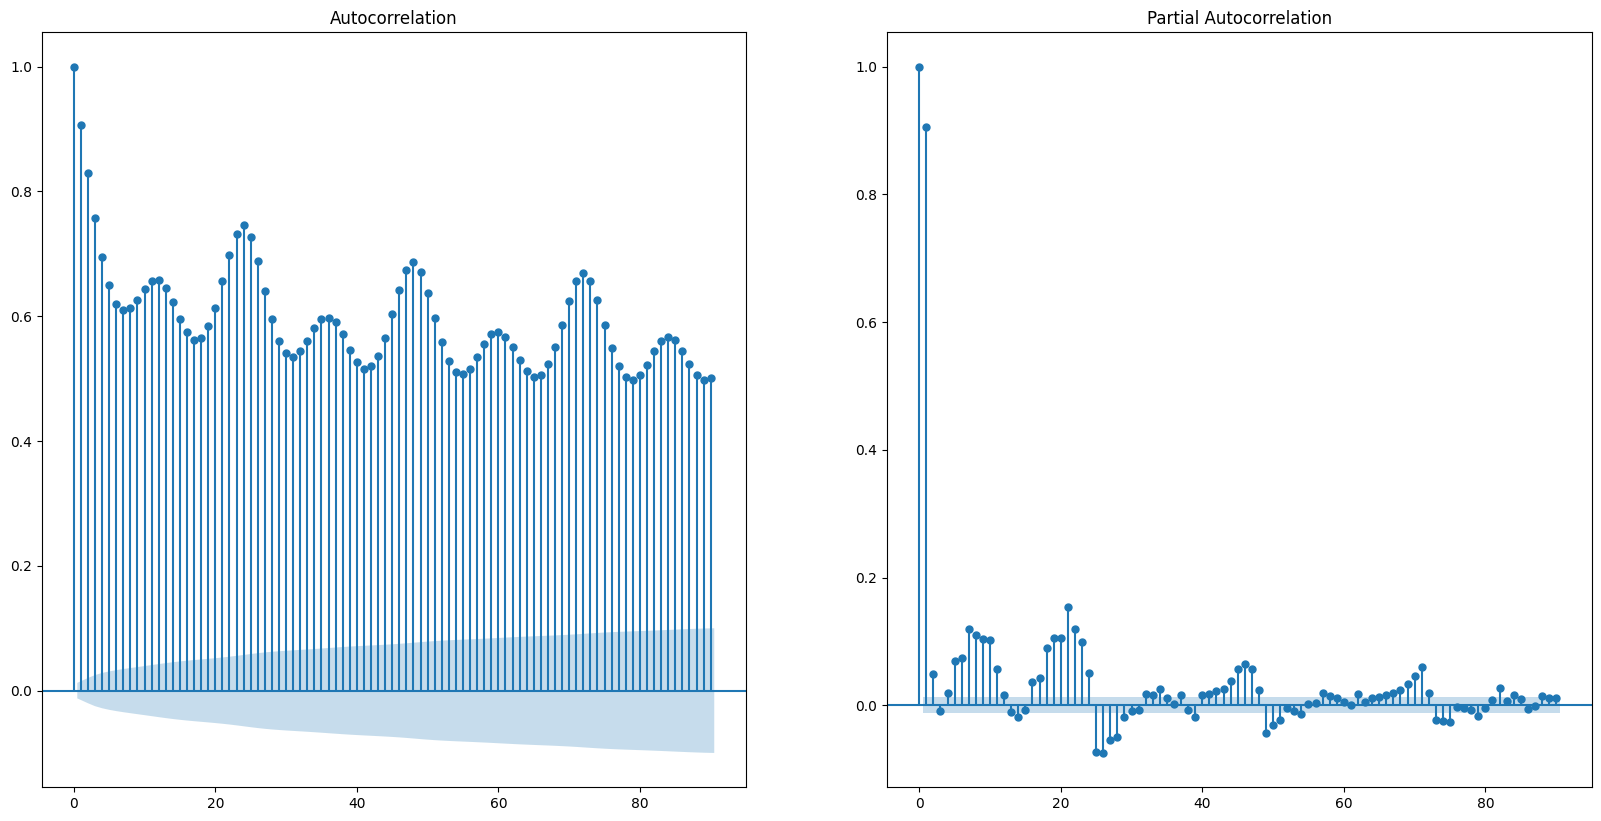

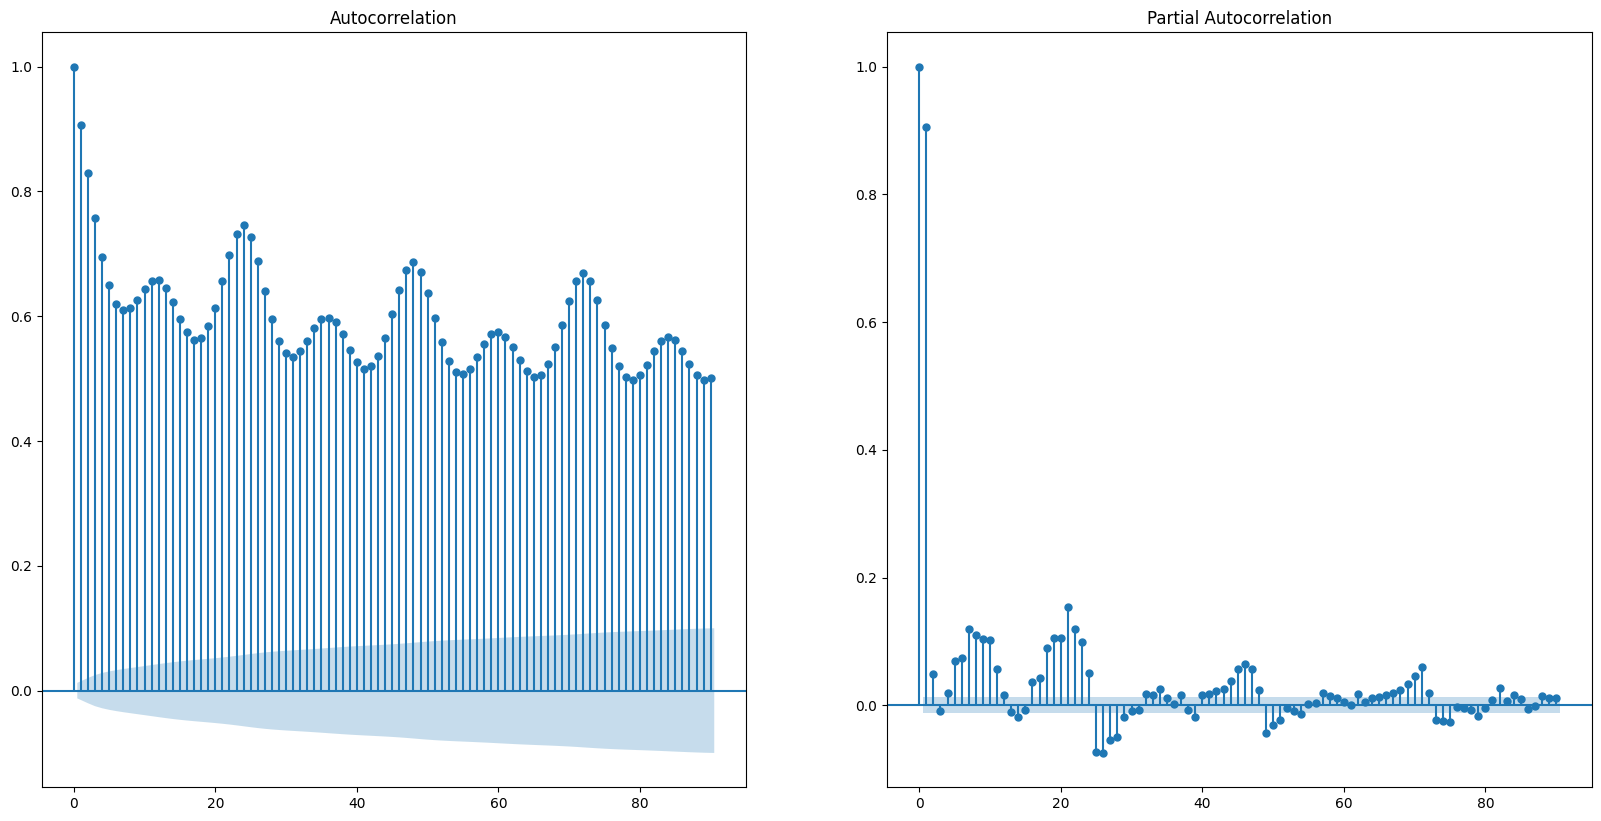

In [32]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,10), dpi= 100)
plot_acf(full_df['SMPS'].tolist(), lags= 90, ax=axes[0])
plot_pacf(full_df['SMPS'].tolist(), lags=90, ax=axes[1])

Decomposition Section

Naive decomposition 

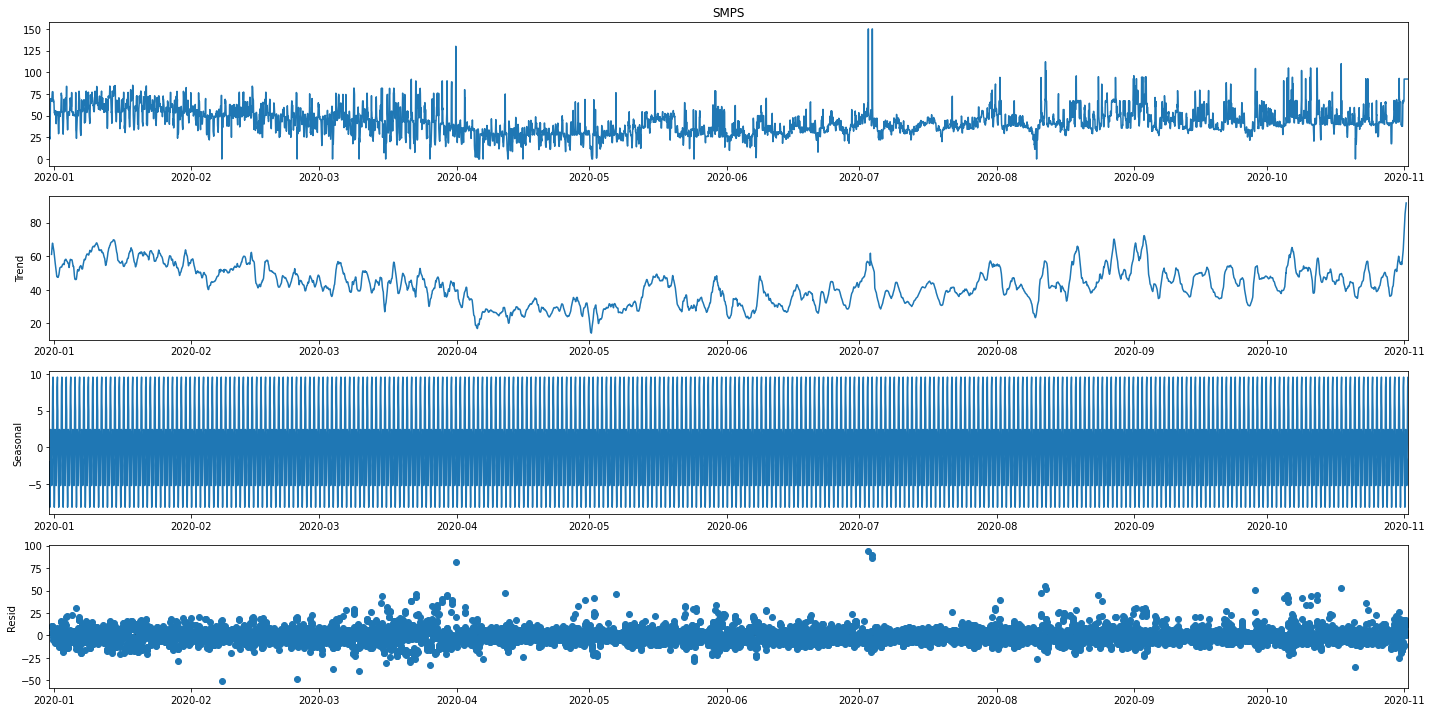

In [26]:
#naive decomposition additive model
result = seasonal_decompose(third_year['SMPS'], model='additive')
plt.rcParams['figure.figsize'] = (20, 10)
result.plot()
plt.show()

In [37]:
len(full_df[full_df['SMPS']<=0])

54

In [38]:
full_df[full_df['SMPS']<=0]

SMPS  Daily_Average_SMP
date                                        
2018-03-13 00:00:00   0.0          36.686667
2018-03-18 08:00:00   0.0          29.412875
2018-03-18 09:00:00   0.0          29.412875
2018-03-18 10:00:00   0.0          29.412875
2018-03-18 11:00:00   0.0          29.412875
2018-03-18 12:00:00   0.0          29.412875
2018-03-18 13:00:00   0.0          29.412875
2018-03-18 14:00:00   0.0          29.412875
2018-03-18 15:00:00   0.0          29.412875
2018-03-18 17:00:00   0.0          29.412875
2018-03-24 01:00:00   0.0          40.519750
2018-03-24 03:00:00   0.0          40.519750
2018-03-24 06:00:00   0.0          40.519750
2018-03-26 00:00:00   0.0          37.213833
2018-04-08 13:00:00   0.0          33.634750
2018-04-08 14:00:00   0.0          33.634750
2018-04-08 15:00:00   0.0          33.634750
2018-04-08 16:00:00   0.0          33.634750
2018-09-27 00:00:00   0.0          51.924792
2018-10-28 15:00:00   0.0          60.806680
2018-10-28 16:00:00   0.0          60.806680
2018-11-29 03:00:00   0.0          58.083542
2018-11-29 04:00:00   0.0          58.083542
2019-01-11 00:00:00   0.0          74.183542
2019-01-30 00:00:00   0.0          66.231792
2019-03-06 00:00:00   0.0          61.733542
2019-03-12 00:00:00   0.0          54.496167
2019-03-22 00:00:00   0.0          45.917167
2019-09-24 00:00:00   0.0          64.469708
2019-10-02 00:00:00   0.0          57.500208
2019-10-06 00:00:00   0.0          55.086833
2019-10-27 15:00:00   0.0          50.139320
2019-11-20 00:00:00   0.0          53.102083
2019-12-22 00:00:00   0.0          46.783708
2019-12-23 00:00:00   0.0          51.020542
2019-12-31 00:00:00   0.0          57.407417
2020-02-08 00:00:00   0.0          49.994375
2020-02-25 00:00:00   0.0          42.427667
2020-03-04 00:00:00   0.0          43.273792
2020-03-10 00:00:00   0.0          43.137750
2020-03-16 00:00:00   0.0          43.584917
2020-03-26 00:00:00   0.0          37.698167
2020-04-06 00:00:00   0.0          22.586333
2020-04-07 00:00:00   0.0          27.112042
2020-04-12 14:00:00   0.0          24.737167
2020-04-12 15:00:00   0.0          24.737167
2020-04-16 00:00:00   0.0          24.559958
2020-05-01 14:00:00   0.0          14.191417
2020-05-01 15:00:00   0.0          14.191417
2020-05-01 16:00:00   0.0          14.191417
2020-05-01 17:00:00   0.0          14.191417
2020-05-24 15:00:00   0.0          29.192042
2020-08-10 00:00:00   0.0          33.686958
2020-10-21 00:00:00   0.0          34.900792

In [ ]:
#naive decomposition multiplicative model
result = seasonal_decompose(third_year['SMPS'], model='multiplicative',period=24)
plt.rcParams['figure.figsize'] = (20, 10)
result.plot()
plt.show()

Stl decomposition

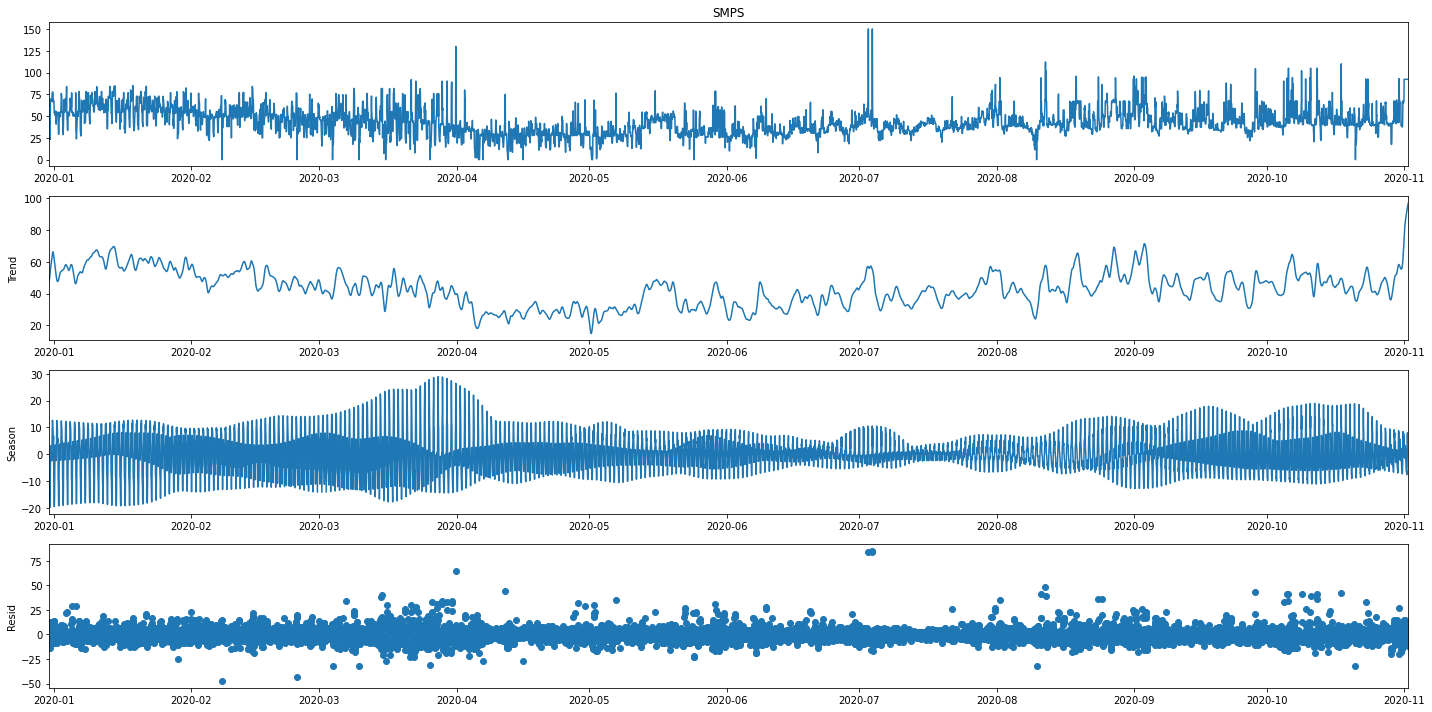

In [39]:
#stl decomposition, better

stl = STL(third_year['SMPS'], seasonal=23,period=24)
res = stl.fit()
plt.rcParams['figure.figsize'] = (20, 10)
fig = res.plot()

hpfilter

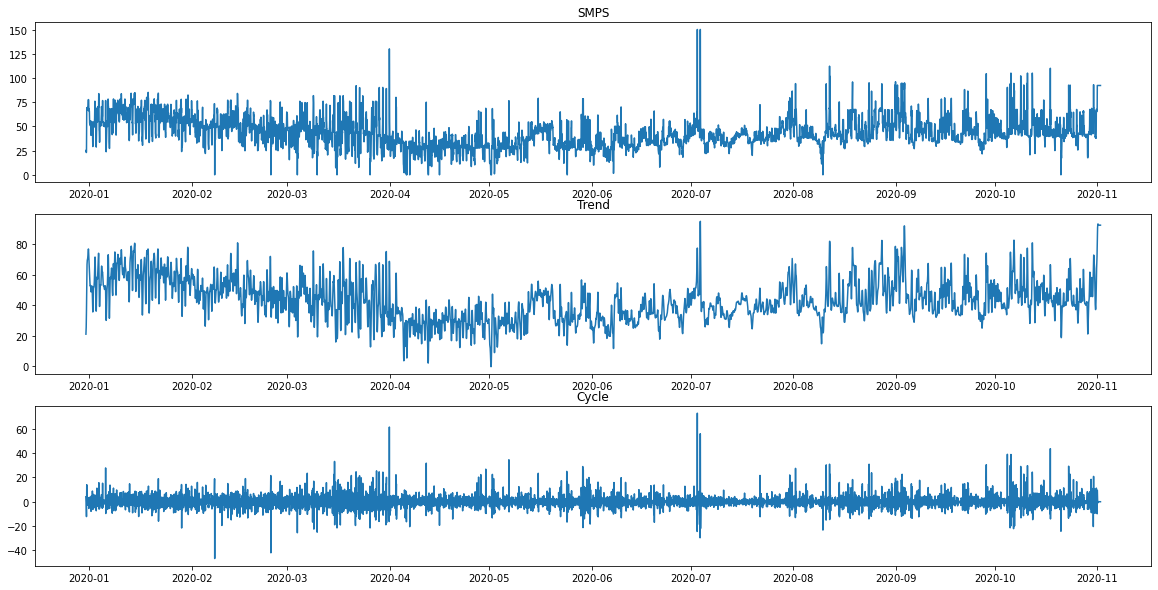

In [24]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(third_year['SMPS'], 6.25)
fig, ax = plt.subplots(3,1)
plt.rcParams['figure.figsize'] = (20, 10)
ax[0].plot(third_year['SMPS'])
ax[0].set_title('SMPS')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

Seasonality Detection with FFT

In [27]:
series = np.array(full_df.SMPS)
N = len(series)


In [28]:
type(series)

numpy.ndarray

In [38]:
series

array([57.883, 58.088, 57.959, ..., 92.223, 92.223, 92.223])

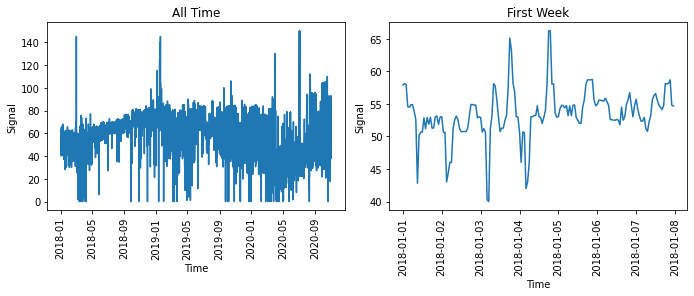

In [29]:
time = full_df.index

plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(time, series, label='signal')
ax1.set_title('All Time')
ax1.set_ylabel( 'Signal' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 24 * 7

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(time[:N], series[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Signal' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ]),
 [Text(-0.05, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.10000000000000002, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25000000000000006, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30')])

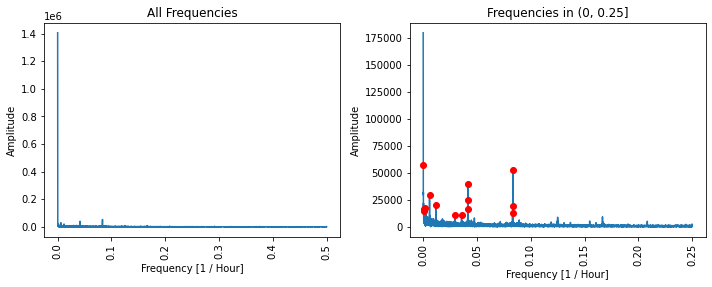

In [30]:
# Plotting power in the frequency domain
fft_output = fft.fft(series)
power = np.abs(fft_output)
freq = fft.fftfreq(len(series))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90)

In [31]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

index  freq (1/hour)     amplitude  period (days)  \
0       3       0.000121  57245.260496     345.666667   
12   2074       0.083333  53132.890228       0.500000   
9    1037       0.041667  40097.615910       1.000000   
4     148       0.005947  29776.516642       7.006757   
8    1034       0.041546  25198.279375       1.002901   
5     296       0.011893  20523.109327       3.503378   
11   2071       0.083213  19731.642410       0.500724   
3      32       0.001286  17312.113976      32.406250   
1      18       0.000723  16743.056888      57.611111   
10   1040       0.041787  16168.510860       0.997115   
2      28       0.001125  15051.176292      37.035714   
13   2077       0.083454  12585.742435       0.499278   
7     889       0.035720  11322.595687       1.166479   
6     741       0.029773  11185.311830       1.399460   

                           fft  
0   52988.894911+21660.952548j  
12  -6347.640861+52752.359942j  
9    6197.473962+39615.781176j  
4  -21464.802562-20637.422182j  
8  -18785.146522+16794.985966j  
5   -5363.447578-19809.882547j  
11 -19718.6702503-715.3709660j  
3    16188.346040+6135.694158j  
1    14427.783159-8495.235551j  
10  -8741.810011+13601.525692j  
2  -10639.653357-10645.923361j  
13   3926.460909+11957.584094j  
7    4244.931878-10496.748375j  
6  -5063.7332830-9973.4550670j

From the above array we can conclude to the following :
    1)the top seasonal pattern corresponds to 346 days
    2)the next top seasonal pattern corresponds to 12 hours
    3)we could also say there is 1-day seasonality 

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

In [26]:
short_term_metrics = pd.DataFrame(columns=['MSE','RMSE','MAPE','sMAPE','MAE','MARNE'])
long_term_metrics = pd.DataFrame(columns=['MSE','RMSE','MAPE','sMAPE','MAE','MARNE'])
short_term_metrics

Empty DataFrame
Columns: [MSE, RMSE, MAPE, sMAPE, MAE, MARNE]
Index: []

In [18]:
def calculate_metrics(actual,predicted):
   
    actual = actual if isinstance(actual,(np.ndarray)) else actual[:len(predicted)].to_numpy()
    pred = predicted if isinstance(predicted,(np.ndarray)) else predicted.to_numpy()
    metrics=[]
    mse = mean_squared_error(actual, pred)
    print('Test MSE: %.5f' % mse)
    metrics.append(mse)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    print('Test RMSE: %.5f' % rmse)
    metrics.append(rmse)
    mape= np.mean(np.abs((actual - pred) / actual)) * 100
    print('Test MAPE: %.5f' % mape)
    metrics.append(mape)
    smape = (100/len(actual)) * np.sum(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred)))
    print('Test sMAPE: %.5f' % smape)
    metrics.append(smape)
    mae= mean_absolute_error(actual, pred)
    print('Test MAE: %.5f' % mae)
    metrics.append(mae)
    marne = (100/len(actual)) * np.sum(np.abs(pred - actual) / (np.max(actual)))
    print('Test MARNE: %.5f' % marne)
    metrics.append(marne)
    return metrics

## 4. Model examination

We now examine various models for both short term and long term predictions

1st method: using TBATS library

In [23]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(12, 345.67*24))
short_tbats_model = estimator.fit(first_two_years_series)
y_forecast = short_tbats_model.forecast(steps=168)

In [24]:
len(third_year)

7343

In [24]:
y_forecast

array([64.9023945 , 63.16022414, 61.29367523, 60.18907619, 60.07877461,
       62.00951413, 64.61750549, 66.34985732, 67.62857425, 67.32173443,
       66.00378757, 64.73541572, 63.32069485, 62.43315157, 60.81057084,
       59.60291869, 60.0640721 , 61.99475902, 64.602775  , 66.33513927,
       67.61386864, 67.30704127, 65.98910686, 64.72074748, 63.30603907,
       62.41850828, 60.79594004, 59.58830039, 60.0494663 , 61.98016573,
       64.58819425, 66.32057104, 67.59931295, 67.29249813, 65.97457628,
       64.70622946, 63.29153363, 62.40401542, 60.78145977, 59.57383271,
       60.03501124, 61.96572328, 64.57376442, 66.30615384, 67.58490839,
       67.27810622, 65.96019702, 64.69186287, 63.27717971, 62.38967418,
       60.76713122, 59.55951686, 60.02070809, 61.95143285, 64.55948671,
       66.29188887, 67.57065616, 67.26386673, 65.94597029, 64.6776489 ,
       63.26297851, 62.37548576, 60.75295559, 59.54535402, 60.00655805,
       61.93729563, 64.5453623 , 66.27777729, 67.55655741, 67.24

In [29]:
short_term_metrics.loc['TBATS'] = calculate_metrics(third_year[:168].SMPS,y_forecast)
short_term_metrics

Test MSE: 227.93633
Test RMSE: 15.09756
Test MAPE: 29.15409
Test sMAPE: 23.47158
Test MAE: 12.79806
Test MARNE: 15.26851


MSE      RMSE       MAPE      sMAPE        MAE      MARNE
TBATS  227.936326  15.09756  29.154092  23.471581  12.798063  15.268507

Text(0, 0.5, 'SMP value')

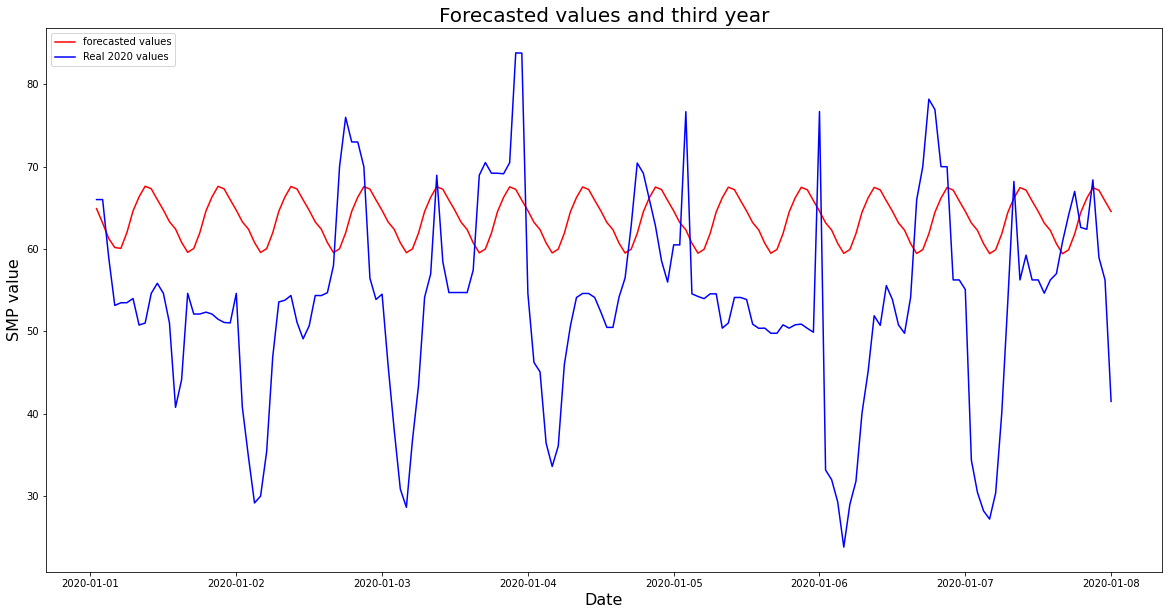

In [29]:
forecasts = y_forecast
real = third_year[:168].SMPS
plt.plot(real.index,forecasts, color='red',label="forecasted values")
plt.plot(real,  color='blue',label="Real 2020 values")
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(loc="upper left")
plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

2nd method : SARIMA model from pmdarima library

In [30]:
#m=12 as the second priamry seasonality is 12 hours
from pmdarima import auto_arima
arima_model = auto_arima(first_two_years_series,
                            start_p=0, d=0, start_q=0,
                            max_p=1,  max_q=1,
                         max_P=1,max_Q=1, max_D=1,
                            max_order=5, m=12,
                            seasonal=True, stationary=True,
                            information_criterion='aic',
                            alpha=0.05,
                            trace=True,
                            error_action='warn',
                            suppress_warnings=True,
                            stepwise=True,
                            n_jobs=1,
                            maxiter=100)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=125382.351, Time=96.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=136055.077, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=110497.291, Time=24.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=121429.741, Time=12.66 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=195278.884, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=110733.425, Time=0.82 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=47.95 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=110570.979, Time=12.36 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=130673.368, Time=31.73 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=110499.254, Time=35.51 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=120010.865, Time=33.62 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=inf, Time=10.09 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 305.551 seconds


In [31]:
y_arima_forecast_168 = arima_model.predict(n_periods=168)
y_arima_forecast_168

array([67.56076686, 66.91834556, 66.18023793, 65.87254485, 66.0095227 ,
       66.07379397, 65.81516498, 65.56772848, 65.32433099, 65.07901579,
       63.60450149, 63.70165637, 63.51286142, 63.33152159, 63.15337982,
       63.03943621, 62.9896275 , 62.94041418, 62.86049739, 62.78879893,
       62.72349458, 62.66303949, 62.45960908, 62.44832137, 62.40598176,
       62.36730657, 62.33139599, 62.30522715, 62.28850478, 62.27336531,
       62.25584456, 62.24042534, 62.22673203, 62.21444457, 62.18572775,
       62.18065154, 62.17237665, 62.16499083, 62.158323  , 62.15315512,
       62.14940511, 62.14609022, 62.1427008 , 62.13974452, 62.1371509 ,
       62.13485966, 62.13071413, 62.12950121, 62.12798985, 62.12665809,
       62.12547515, 62.12452595, 62.12379306, 62.12315216, 62.12253657,
       62.12200233, 62.12153685, 62.12112934, 62.12051824, 62.12027472,
       62.12000922, 62.11977711, 62.11957303, 62.11940571, 62.11927186,
       62.1191555 , 62.11904773, 62.11895448, 62.11887359, 62.11

In [32]:
short_term_metrics.loc['PMDARIMA_168'] = calculate_metrics(third_year.SMPS,y_arima_forecast_168)
short_term_metrics

Test MSE: 218.10325
Test RMSE: 14.76832
Test MAPE: 28.00344
Test sMAPE: 22.43595
Test MAE: 12.12901
Test MARNE: 14.47031


MSE       RMSE       MAPE      sMAPE        MAE  \
TBATS         227.936326  15.097560  29.154092  23.471581  12.798063   
PMDARIMA_168  218.103247  14.768319  28.003443  22.435951  12.129010   

                  MARNE  
TBATS         15.268507  
PMDARIMA_168  14.470306

Text(0, 0.5, 'SMP value')

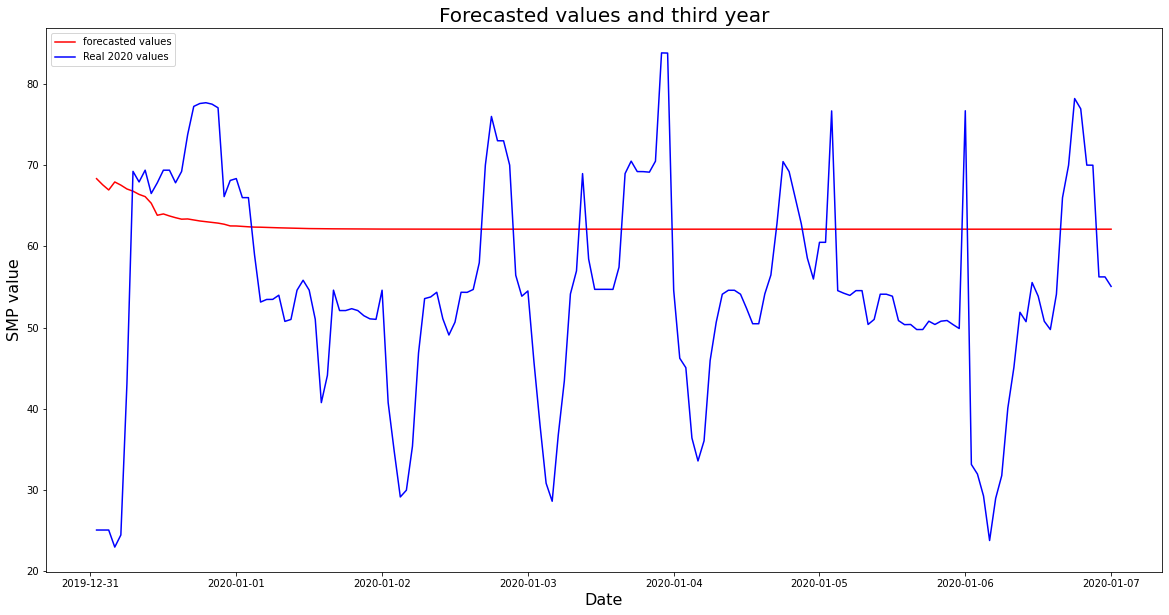

In [29]:
forecasts = y_arima_forecast_168
real = third_year[:168].SMPS
plt.plot(real.index,forecasts, color='red',label="forecasted values")
plt.plot(real,  color='blue',label="Real 2020 values")
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(loc="upper left")

plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [31]:
type(forecasts)

numpy.ndarray

In [33]:
from scipy.stats import variation
variation(forecasts)

0.019092214655812508

3rd method SARIMAX with single seasonality 

We use grid search to find optimal model

In [33]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
test= range(0, 10)
for param in test:

    for param_seasonal in seasonal_pdq:
    
        mod = sm.tsa.statespace.SARIMAX(first_two_years_series,
                                            order=(0,0,param),
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA order{} x{} - AIC:{}'.format(param, param_seasonal, results.aic))
   

ARIMA order0 x(0, 0, 0, 12) - AIC:195267.91508559356
ARIMA order0 x(0, 0, 1, 12) - AIC:178620.63325173256
ARIMA order0 x(0, 1, 0, 12) - AIC:135449.95285977094
ARIMA order0 x(0, 1, 1, 12) - AIC:125294.97412801484
ARIMA order0 x(1, 0, 0, 12) - AIC:135316.43640892504
ARIMA order0 x(1, 0, 1, 12) - AIC:125378.46315371283
ARIMA order0 x(1, 1, 0, 12) - AIC:126133.59837718772
ARIMA order0 x(1, 1, 1, 12) - AIC:125290.10331076724
ARIMA order1 x(0, 0, 0, 12) - AIC:173313.6988195946
ARIMA order1 x(0, 0, 1, 12) - AIC:158609.98823613525
ARIMA order1 x(0, 1, 0, 12) - AIC:126044.70895106015
ARIMA order1 x(0, 1, 1, 12) - AIC:115568.68438809941
ARIMA order1 x(1, 0, 0, 12) - AIC:125843.01694168535
ARIMA order1 x(1, 0, 1, 12) - AIC:115647.66049294235
ARIMA order1 x(1, 1, 0, 12) - AIC:118147.02925600266
ARIMA order1 x(1, 1, 1, 12) - AIC:115570.67860716651
ARIMA order2 x(0, 0, 0, 12) - AIC:157445.50355431114
ARIMA order2 x(0, 0, 1, 12) - AIC:147666.96449763852
ARIMA order2 x(0, 1, 0, 12) - AIC:122725.534001

In [34]:
arima_model_2 = sm.tsa.statespace.SARIMAX(first_two_years_series,
                                order=(0, 0, 9),seasonal_order=(1,1,1,12))

result = arima_model_2.fit()

print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7582      0.003    297.375      0.000       0.753       0.763
ma.L2          0.6280      0.005    134.057      0.000       0.619       0.637
ma.L3          0.5061      0.006     84.623      0.000       0.494       0.518
ma.L4          0.3854      0.006     62.765      0.000       0.373       0.397
ma.L5          0.3031      0.007     45.550      0.000       0.290       0.316
ma.L6          0.2195      0.007     30.079      0.000       0.205       0.234
ma.L7          0.1590      0.007     22.264      0.000       0.145       0.173
ma.L8          0.1135      0.007     16.433      0.000       0.100       0.127
ma.L9          0.0573      0.006     10.350      0.000       0.046       0.068
ar.S.L12      -0.0243      0.006     -3.927      0.000      -0.036      -0.012
ma.S.L12      -0.9536      0.002   -503.770      0.0

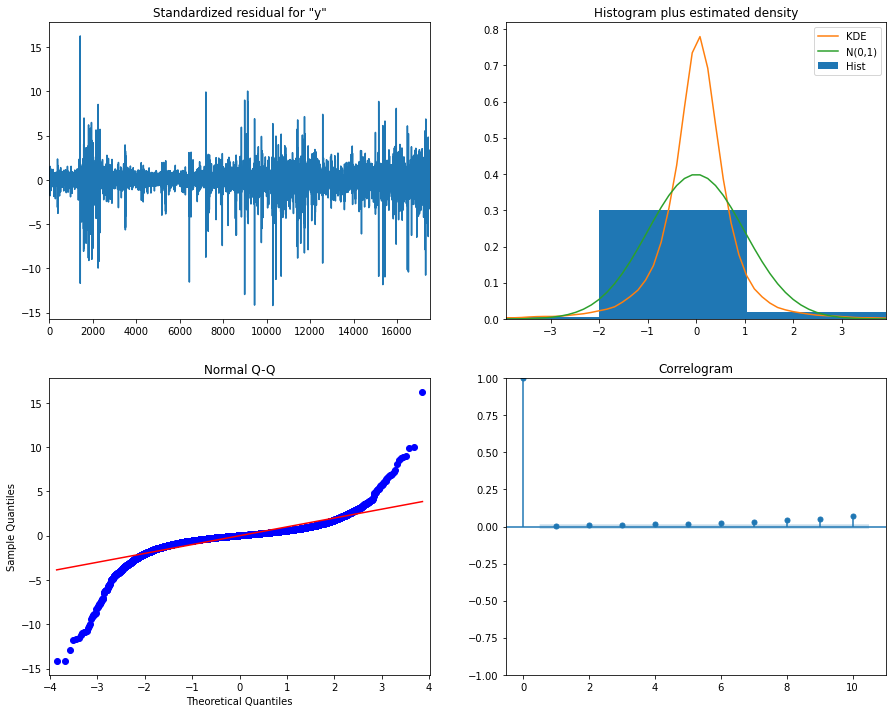

In [49]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
arimax_forecast= result.forecast(steps=168)
arimax_forecast

array([56.96024635, 55.33660564, 52.12703514, 50.44641212, 50.69739683,
       53.2609115 , 57.68878475, 62.9319259 , 64.70714435, 65.06242722,
       63.43111214, 63.13113556, 54.1400536 , 53.84110367, 51.58717122,
       50.5984556 , 50.99443835, 53.67268766, 58.16361778, 63.25453681,
       64.83594198, 65.35402714, 63.49678369, 63.25242194, 54.20857529,
       53.8774396 , 51.60028819, 50.59476143, 50.98722119, 53.66268281,
       58.15208085, 63.24669839, 64.83281261, 65.34694219, 63.49518808,
       63.24947506, 54.20691043, 53.87655675, 51.59996949, 50.59485118,
       50.98739654, 53.6629259 , 58.15236117, 63.24688884, 64.83288864,
       65.34711433, 63.49522685, 63.24954666, 54.20695088, 53.8765782 ,
       51.59997723, 50.594849  , 50.98739228, 53.66291999, 58.15235435,
       63.24688421, 64.8328868 , 65.34711015, 63.49522591, 63.24954492,
       54.2069499 , 53.87657768, 51.59997705, 50.59484906, 50.98739239,
       53.66292013, 58.15235452, 63.24688433, 64.83288684, 65.34

In [36]:
len(arimax_forecast)

168

Text(0, 0.5, 'SMP value')

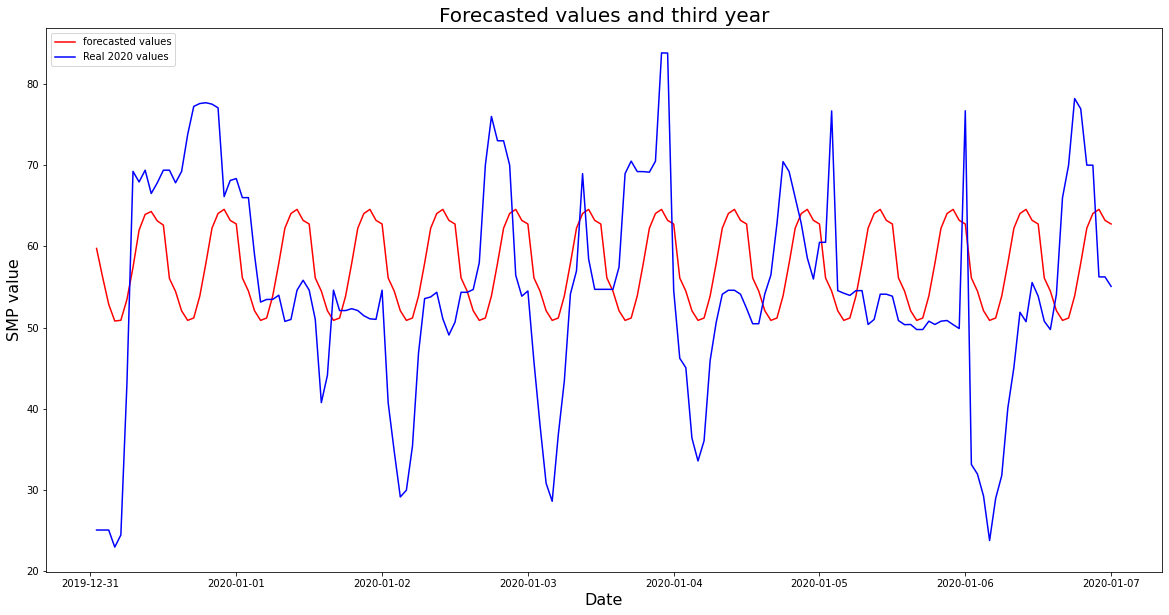

In [42]:
forecasts = arimax_forecast
real = third_year[:168].SMPS
plt.plot(real.index,forecasts, color='red',label="forecasted values")
plt.plot(real,  color='blue',label="Real 2020 values")
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(loc="upper left")

plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [37]:
short_term_metrics.loc['SARIMAX_ARMA_168'] = calculate_metrics(third_year[:168].SMPS,arimax_forecast)
short_term_metrics

Test MSE: 145.44275
Test RMSE: 12.05996
Test MAPE: 21.86549
Test sMAPE: 19.24457
Test MAE: 10.15710
Test MARNE: 12.11775


MSE       RMSE       MAPE      sMAPE        MAE  \
TBATS             227.936326  15.097560  29.154092  23.471581  12.798063   
PMDARIMA_168      218.103247  14.768319  28.003443  22.435951  12.129010   
SARIMAX_ARMA_168  145.442750  12.059965  21.865494  19.244574  10.157102   

                      MARNE  
TBATS             15.268507  
PMDARIMA_168      14.470306  
SARIMAX_ARMA_168  12.117754

In [39]:
short_term_metrics.to_excel('short_term_prediction.xlsx', header=True)

3rd method SARIMAX with Fourier Terms -Long term forecasts: Handling multiple seasonalities with Fourier series

In [152]:
def train_test(data, test_size = 0.15):
    """
    
        Perform train-test split with respect to time series structure
        
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'SDGE' in this notebook
        - test_size: size of test set
        - scale: if True, then the columns in the -'cols_to_transform'- list will be scaled using StandardScaler
        - include_test_scale: If True, the StandardScaler fits the data on the training as well as the test set; if False, then
          the StandardScaler fits only on the training set.
        
    """
    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]
    
    
    
    return X_train, X_test, y_train, y_test

In [19]:

first_two_years,first_two_years_series,third_year,third_year_series =initialize_datasets(full_df)

In [20]:
def add_fourier_terms(df, year_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
            sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:  same as year_k but for daily periods
    """
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)


    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24) 


In [21]:
add_fourier_terms(first_two_years, year_k= 2, week_k=2 , day_k=2)

In [126]:
first_two_years.columns

Index(['SMPS', 'Daily_Average_SMP', 'year_sin1', 'year_cos1', 'year_sin2',
       'year_cos2', 'week_sin1', 'week_cos1', 'week_sin2', 'week_cos2',
       'hour_sin1', 'hour_cos1', 'hour_sin2', 'hour_cos2'],
      dtype='object')

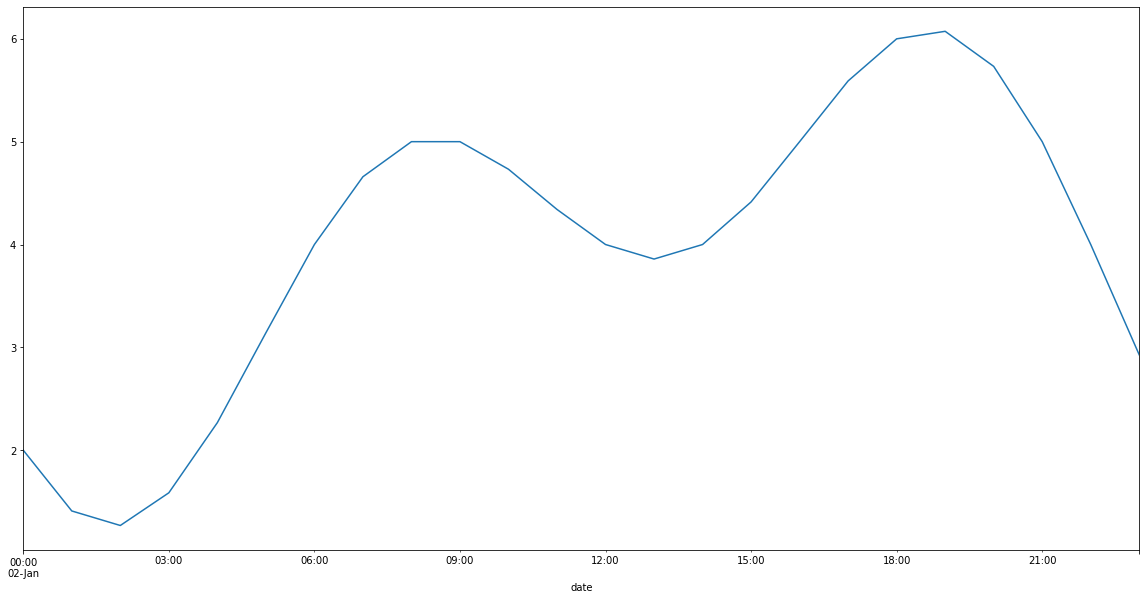

In [116]:
# Visualizing the new variables on hour seasonality
pd.plotting.register_matplotlib_converters()
_ = (1-first_two_years.loc['01-02-2018':'01-02-2018', [col for col in first_two_years if col.startswith('hour')]]).sum(axis = 1).plot()

In [53]:
first_two_years.index

PeriodIndex(['2018-01-01 00:00', '2018-01-01 01:00', '2018-01-01 02:00',
             '2018-01-01 03:00', '2018-01-01 04:00', '2018-01-01 05:00',
             '2018-01-01 06:00', '2018-01-01 07:00', '2018-01-01 08:00',
             '2018-01-01 09:00',
             ...
             '2019-12-30 14:00', '2019-12-30 15:00', '2019-12-30 16:00',
             '2019-12-30 17:00', '2019-12-30 18:00', '2019-12-30 19:00',
             '2019-12-30 20:00', '2019-12-30 21:00', '2019-12-30 22:00',
             '2019-12-30 23:00'],
            dtype='period[H]', name='date', length=17520, freq='H')

In [27]:
first_two_years.isna().sum()

SMPS                 0
Daily_Average_SMP    0
year_sin1            0
year_cos1            0
year_sin2            0
year_cos2            0
week_sin1            0
week_cos1            0
week_sin2            0
week_cos2            0
hour_sin1            0
hour_cos1            0
hour_sin2            0
hour_cos2            0
dtype: int64

In [46]:
exog.isna().sum()

sin365      0
cos365      0
sin365_2    0
cos365_2    0
dtype: int64

In [22]:
exog = pd.DataFrame({'date': first_two_years.index})

exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear*24 / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear*24 / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear*24 / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear*24 / 365.25)
exog = exog.drop(columns=['date'])
exog_to_train = exog
exog_to_test = pd.DataFrame({'date': third_year.index})
exog_to_test = exog_to_test.set_index(pd.PeriodIndex(exog_to_test['date'], freq='H'))
exog_to_test['sin365'] = np.sin(2 * np.pi * exog_to_test.index.dayofyear*24 / 365.25)
exog_to_test['cos365'] = np.cos(2 * np.pi * exog_to_test.index.dayofyear*24 / 365.25)
exog_to_test['sin365_2'] = np.sin(4 * np.pi * exog_to_test.index.dayofyear*24 / 365.25)
exog_to_test['cos365_2'] = np.cos(4 * np.pi * exog_to_test.index.dayofyear*24 / 365.25)
exog_to_test = exog_to_test.drop(columns=['date'])


In [118]:
first_two_years.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', length=17544, freq=None)

In [23]:

first_two_years.set_index(first_two_years.index.to_period("H"),inplace=True)

In [57]:
first_two_years.index

PeriodIndex(['2018-01-01 00:00', '2018-01-01 01:00', '2018-01-01 02:00',
             '2018-01-01 03:00', '2018-01-01 04:00', '2018-01-01 05:00',
             '2018-01-01 06:00', '2018-01-01 07:00', '2018-01-01 08:00',
             '2018-01-01 09:00',
             ...
             '2019-12-30 14:00', '2019-12-30 15:00', '2019-12-30 16:00',
             '2019-12-30 17:00', '2019-12-30 18:00', '2019-12-30 19:00',
             '2019-12-30 20:00', '2019-12-30 21:00', '2019-12-30 22:00',
             '2019-12-30 23:00'],
            dtype='period[H]', name='date', length=17520, freq='H')

In [24]:
model_opt = sm.tsa.statespace.SARIMAX(first_two_years.SMPS, order=(0,0,3), seasonal_order=(0, 1, 1, 12), exog = exog_to_train)
results = model_opt.fit()

In [130]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 SMPS   No. Observations:                17544
Model:             SARIMAX(0, 0, 3)x(0, 1, [1], 12)   Log Likelihood              -55104.009
Date:                              Tue, 23 Mar 2021   AIC                         110226.018
Time:                                      04:13:09   BIC                         110295.964
Sample:                                           0   HQIC                        110249.049
                                            - 17544                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365         0.2543      0.150      1.697      0.090      -0.039       0.548
cos365         0.3951      0.149      2.657      0.008       0.104       0.687
sin365_2       0.4982      0.130      3.823      0.000       0.243       0.754
cos365_2       0.2054      0.125      1.642      0.101      -0.040       0.451
ma.L1          0.7591      0.003    283.636      0.000       0.754       0.764
ma.L2          0.5436      0.004    128.772      0.000       0.535       0.552
ma.L3          0.2898      0.004     70.777      0.000       0.282       0.298
ma.S.L12      -0.9376      0.002   -448.860      0.000      -0.942      -0.934
sigma2        31.3981      0.093    338.552      0.000      31.216      31.580
===================================================================================
Ljung-Box (L1) (Q):                  70.64   Jarque-Bera (JB):            511064.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

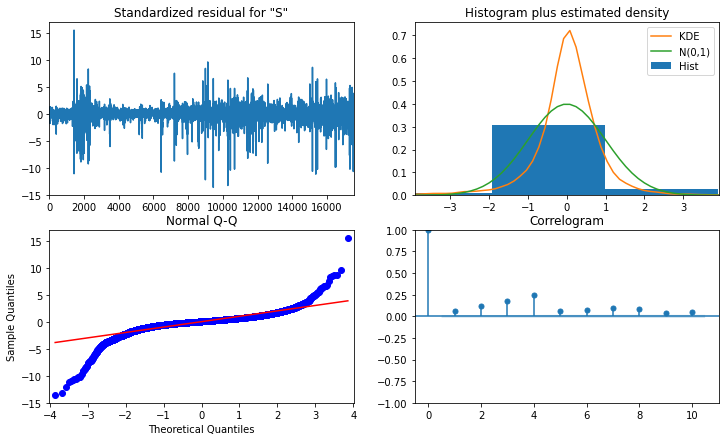

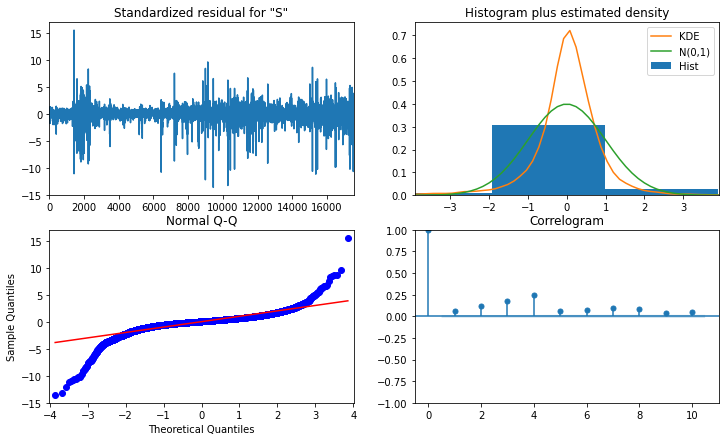

In [131]:
results.plot_diagnostics(figsize=(12, 7))

In [132]:
exog_to_test.index

PeriodIndex(['2019-12-31 01:00', '2019-12-31 02:00', '2019-12-31 03:00',
             '2019-12-31 04:00', '2019-12-31 05:00', '2019-12-31 06:00',
             '2019-12-31 07:00', '2019-12-31 08:00', '2019-12-31 09:00',
             '2019-12-31 10:00',
             ...
             '2020-11-01 14:00', '2020-11-01 15:00', '2020-11-01 16:00',
             '2020-11-01 17:00', '2020-11-01 18:00', '2020-11-01 19:00',
             '2020-11-01 20:00', '2020-11-01 21:00', '2020-11-01 22:00',
             '2020-11-01 23:00'],
            dtype='period[H]', name='date', length=7367, freq='H')

In [25]:
pred = results.get_forecast(steps = 24*7, exog = exog_to_test.iloc[:24*7, :])
pred_ci_2 = pred.conf_int()
pred_ci_2

lower SMPS  upper SMPS
17544   44.747263   66.712197
17545   41.372613   68.948689
17546   38.354935   68.404733
17547   36.064735   66.781435
17548   36.618512   67.335212
...           ...         ...
17707   47.242034   78.725447
17708   48.823225   80.306638
17709   49.492727   80.976140
17710   47.571470   79.054883
17711   47.859206   79.342618

[168 rows x 2 columns]

Text(0, 0.5, 'SMP value')

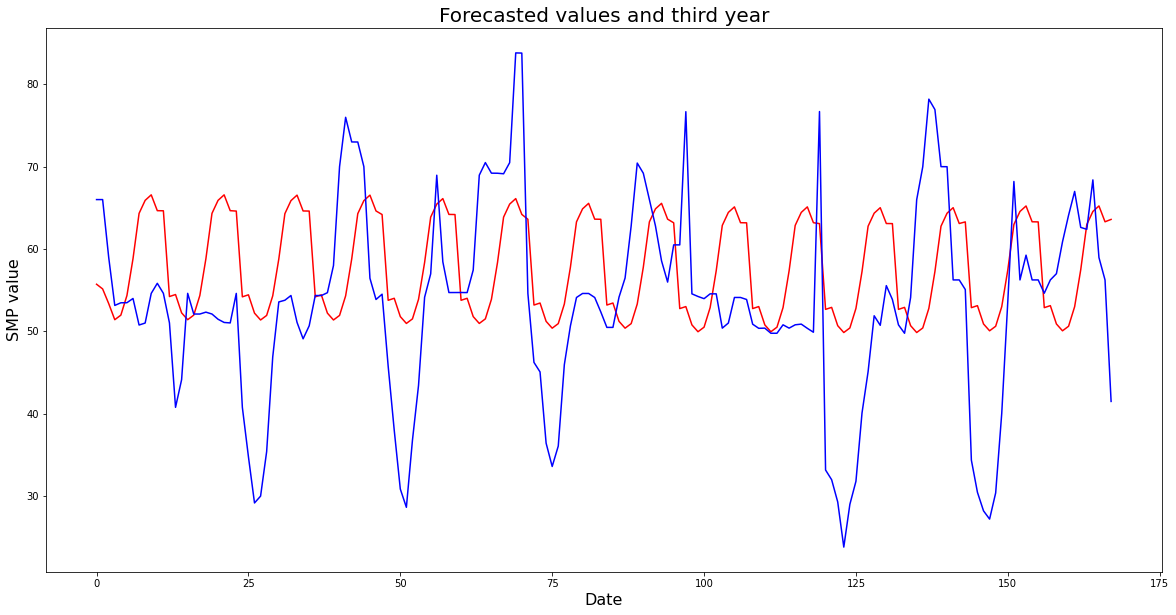

In [29]:
all_data = np.array(pred.predicted_mean)
real = np.array(third_year_series)
plt.plot(all_data[:168], color='red')
plt.plot(real[:168],  color='blue')
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [30]:
short_term_metrics.loc['SARIMAX_WITH_FOURIER_SHORT'] = calculate_metrics(third_year[:168].SMPS,all_data[:168])
short_term_metrics

Test MSE: 146.53024
Test RMSE: 12.10497
Test MAPE: 21.89567
Test sMAPE: 19.30293
Test MAE: 10.20554
Test MARNE: 12.17554


MSE       RMSE       MAPE      sMAPE  \
SARIMAX_WITH_FOURIER_SHORT  146.53024  12.104968  21.895665  19.302929   

                                  MAE      MARNE  
SARIMAX_WITH_FOURIER_SHORT  10.205541  12.175545

In [28]:
len(third_year_series)

7343

long term 1000 hours

In [31]:
long_pred = results.get_forecast(steps = 1000, exog = exog_to_test.iloc[:1000, :])
pred_ci_2 = long_pred.conf_int()
pred_ci_2


lower SMPS  upper SMPS
17544   44.747263   66.712197
17545   41.372613   68.948689
17546   38.354935   68.404733
17547   36.064735   66.781435
17548   36.618512   67.335212
...           ...         ...
18539   45.547131   80.822149
18540   35.120090   70.421687
18541   35.355834   70.672735
18542   33.128333   68.453080
18543   32.295882   67.622859

[1000 rows x 2 columns]

Text(0, 0.5, 'SMP value')

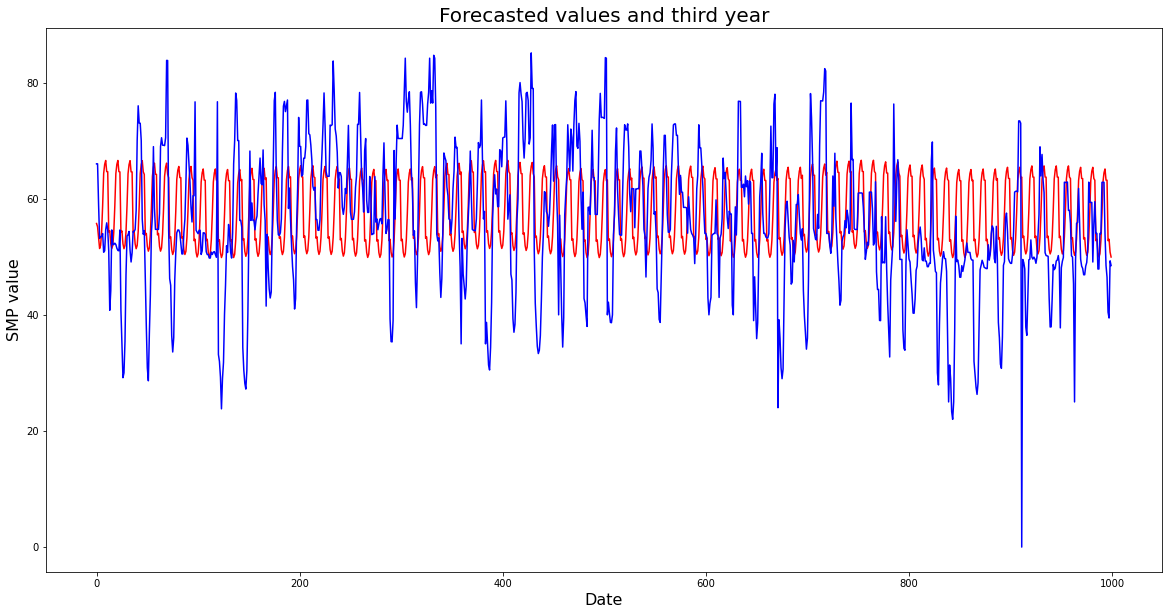

In [32]:
all_data = np.array(long_pred.predicted_mean)
real = np.array(third_year_series)
plt.plot(all_data[:1000], color='red')
plt.plot(real[:1000],  color='blue')
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [33]:
len(all_data)

1000

In [34]:
long_term_metrics.loc['SARIMAX_WITH_FOURIER_OPT_LONG_1000'] = calculate_metrics(third_year.SMPS[:1000],all_data[:1000])
long_term_metrics

Test MSE: 138.43975
Test RMSE: 11.76604
Test MAPE: inf
Test sMAPE: 17.30671
Test MAE: 9.46952
Test MARNE: 11.12634


MSE       RMSE  MAPE     sMAPE  \
SARIMAX_WITH_FOURIER_OPT_LONG_1000  138.439752  11.766042   inf  17.30671   

                                        MAE      MARNE  
SARIMAX_WITH_FOURIER_OPT_LONG_1000  9.46952  11.126343

long term 7343 hours

In [35]:
ultra_long_pred = results.get_forecast(steps = 7343, exog = exog_to_test.iloc[:7343, :])
pred_ci_3 = ultra_long_pred.conf_int()
pred_ci_3

lower SMPS  upper SMPS
17544   44.747263   66.712197
17545   41.372613   68.948689
17546   38.354935   68.404733
17547   36.064735   66.781435
17548   36.618512   67.335212
...           ...         ...
24882   30.642360   87.077510
24883   36.145222   92.580371
24884   37.726412   94.161562
24885   38.395914   94.831064
24886   36.474658   92.909807

[7343 rows x 2 columns]

In [62]:
type(ultra_long_pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [45]:
len(third_year_series)

7343

Text(0, 0.5, 'SMP value')

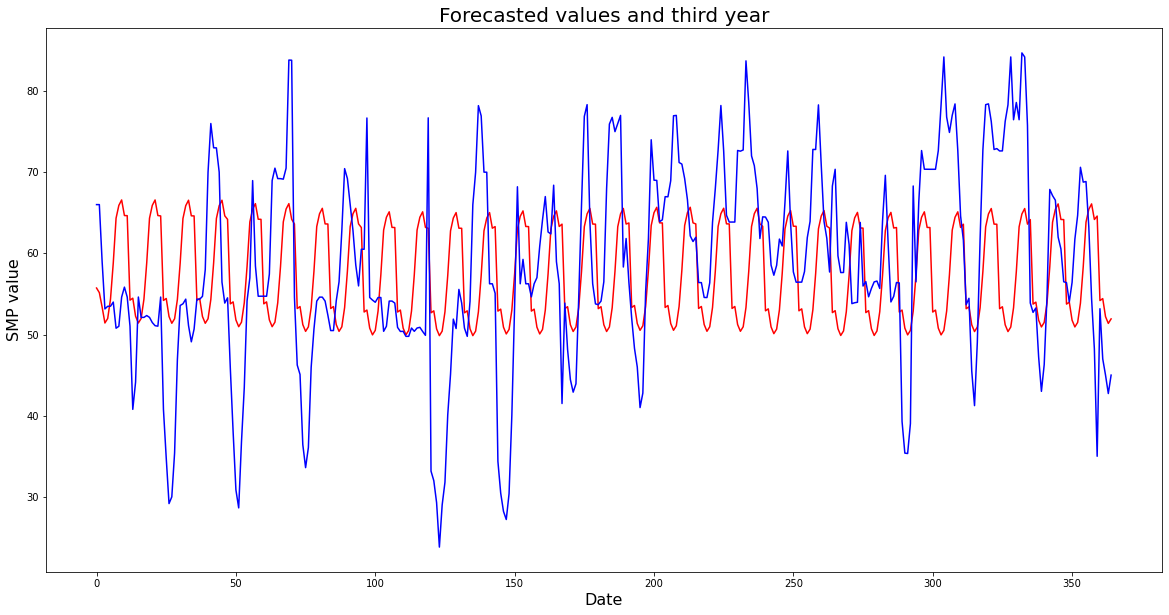

In [36]:
all_data = np.array(ultra_long_pred.predicted_mean)
real = np.array(third_year_series)
plt.plot(all_data[:365], color='red')
plt.plot(real[:365],  color='blue')
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [37]:
long_term_metrics.loc['SARIMAX_WITH_FOURIER_OPT_LONG_7343'] = calculate_metrics(third_year.SMPS[:7343],all_data[:7343])
long_term_metrics

Test MSE: 432.78095
Test RMSE: 20.80339
Test MAPE: inf
Test sMAPE: 38.29656
Test MAE: 17.73978
Test MARNE: 11.82258


MSE       RMSE  MAPE      sMAPE  \
SARIMAX_WITH_FOURIER_OPT_LONG_1000  138.439752  11.766042   inf  17.306710   
SARIMAX_WITH_FOURIER_OPT_LONG_7343  432.780954  20.803388   inf  38.296559   

                                          MAE      MARNE  
SARIMAX_WITH_FOURIER_OPT_LONG_1000   9.469520  11.126343  
SARIMAX_WITH_FOURIER_OPT_LONG_7343  17.739782  11.822580

In [38]:
from scipy.stats import variation

variation(ultra_long_pred.predicted_mean)

0.10211140564732343

As expected SARIMA provides a poor model as it is unable to model yearly seasonality. TBATS and SARIMAX with Fourier Terms provide much better models.Unfortunately BATS and TBATS capabilities do not come for free. The method is very generic. Under the hood it builds and evaluates many model candidates. This results in slowness of the computation. It may be crucial when one needs to train models for lots of parallel time series.
Unlike SARIMAX, BATS and TBATS do not allow for exogenous variables to be added to the model to improve forecasts.

Prophet

In [39]:
first_two_years,first_two_years_series,third_year,third_year_series =initialize_datasets(full_df)

In [16]:
from fbprophet import Prophet
from pandas import to_datetime
def init_Training_df_for_prophet(dataframe):
    train_df = dataframe.copy()
    train_df.reset_index(inplace=True)
    train_df.rename(columns={'date':'ds', 'SMPS':'y'},inplace=True)
    train_df['ds']= to_datetime(train_df['ds'])
    return train_df

Importing plotly failed. Interactive plots will not work.


In [41]:
def init_Test_df_for_prophet(dataframe):
    test_df = dataframe.copy()
    test_df.reset_index(inplace=True)
    test_df.rename(columns={'date':'ds', 'SMPS':'y'},inplace=True)
    test_df['ds']= to_datetime(test_df['ds'])
    df_predict=test_df[['ds']]
    return test_df,df_predict

In [51]:
third_year

SMPS  Daily_Average_SMP
date                                          
2020-01-01 01:00:00  66.009          53.883417
2020-01-01 02:00:00  66.009          53.883417
2020-01-01 03:00:00  58.989          53.883417
2020-01-01 04:00:00  53.156          53.883417
2020-01-01 05:00:00  53.477          53.883417
...                     ...                ...
2020-11-01 19:00:00  92.223          92.223000
2020-11-01 20:00:00  92.223          92.223000
2020-11-01 21:00:00  92.223          92.223000
2020-11-01 22:00:00  92.223          92.223000
2020-11-01 23:00:00  92.223          92.223000

[7343 rows x 2 columns]

In [42]:
train_df = init_Training_df_for_prophet(first_two_years)
train_df

ds       y  Daily_Average_SMP
0     2018-01-01 00:00:00  57.883          52.852167
1     2018-01-01 01:00:00  58.088          52.852167
2     2018-01-01 02:00:00  57.959          52.852167
3     2018-01-01 03:00:00  54.575          52.852167
4     2018-01-01 04:00:00  54.470          52.852167
...                   ...     ...                ...
17539 2019-12-31 19:00:00  77.689          57.407417
17540 2019-12-31 20:00:00  77.515          57.407417
17541 2019-12-31 21:00:00  77.064          57.407417
17542 2019-12-31 22:00:00  66.134          57.407417
17543 2019-12-31 23:00:00  68.123          57.407417

[17544 rows x 3 columns]

FBProphet auto model with test dataset whole 2020.Long term prediction

In [43]:
test_df,df_predict = init_Test_df_for_prophet(third_year)

In [44]:
auto_model = Prophet(yearly_seasonality=True)
auto_model.fit(train_df)

In [45]:
auto_forecast = auto_model.predict(df_predict)
auto_forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2020-01-01 01:00:00  56.068280   45.723221   67.130106    56.068280   
1 2020-01-01 02:00:00  56.066536   43.728014   63.904834    56.066536   
2 2020-01-01 03:00:00  56.064793   41.019092   62.399863    56.064793   
3 2020-01-01 04:00:00  56.063050   41.008144   62.091144    56.063050   
4 2020-01-01 05:00:00  56.061307   42.629451   63.180116    56.061307   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    56.068280        0.200233              0.200233              0.200233   
1    56.066536       -1.822659             -1.822659             -1.822659   
2    56.064793       -3.696806             -3.696806             -3.696806   
3    56.063050       -4.446961             -4.446961             -4.446961   
4    56.061307       -3.468453             -3.468453             -3.468453   

      daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0 -1.621205  ...  0.420598      0.420598      0.420598  1.400840   
1 -3.620228  ...  0.382607      0.382607      0.382607  1.414962   
2 -5.482124  ...  0.356152      0.356152      0.356152  1.429167   
3 -6.231611  ...  0.341196      0.341196      0.341196  1.443454   
4 -5.263839  ...  0.337563      0.337563      0.337563  1.457823   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      1.400840      1.400840                   0.0   
1      1.414962      1.414962                   0.0   
2      1.429167      1.429167                   0.0   
3      1.443454      1.443454                   0.0   
4      1.457823      1.457823                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  56.268513  
1                         0.0                         0.0  54.243877  
2                         0.0                         0.0  52.367988  
3                         0.0                         0.0  51.616089  
4                         0.0                         0.0  52.592854  

[5 rows x 22 columns]

In [29]:
auto_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

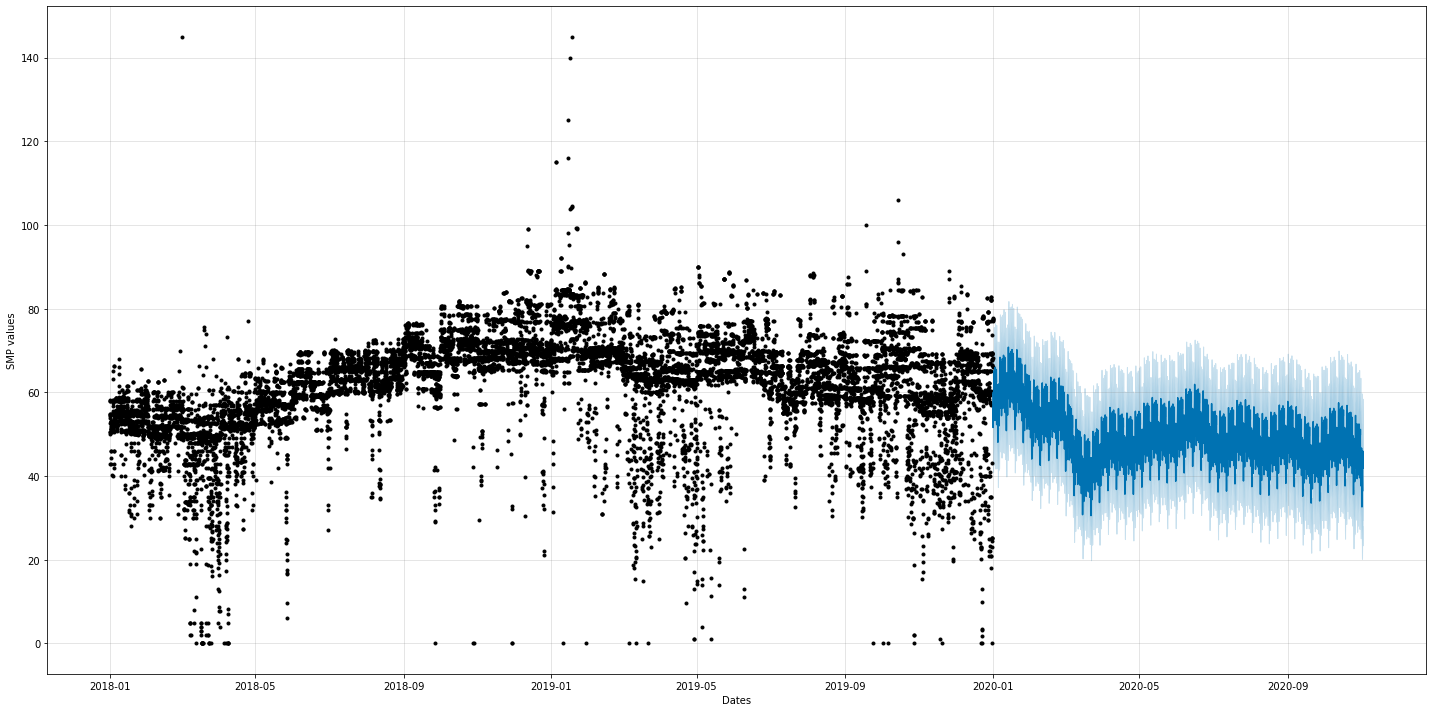

In [46]:
_ = auto_model.plot(auto_forecast, uncertainty = True, xlabel = 'Dates', ylabel = 'SMP values',figsize=(20, 10))

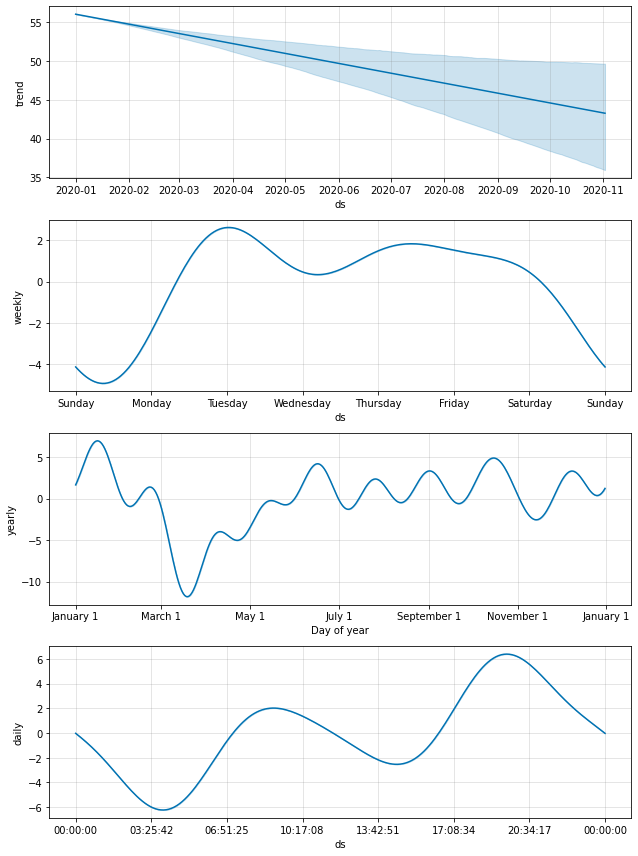

In [30]:
_ = auto_model.plot_components(auto_forecast)


In [49]:
test_df[['y']]

y
0     66.009
1     66.009
2     58.989
3     53.156
4     53.477
...      ...
7338  92.223
7339  92.223
7340  92.223
7341  92.223
7342  92.223

[7343 rows x 1 columns]

In [47]:
long_term_metrics.loc['prophet_auto'] = calculate_metrics(test_df[['y']],auto_forecast.yhat)
long_term_metrics


Test MSE: 224.04725
Test RMSE: 14.96821
Test MAPE: inf
Test sMAPE: 234989.65181
Test MAE: 11.66799
Test MARNE: 68550.81785


MSE       RMSE  MAPE  \
SARIMAX_WITH_FOURIER_OPT_LONG_1000  138.439752  11.766042   inf   
SARIMAX_WITH_FOURIER_OPT_LONG_7343  432.780954  20.803388   inf   
prophet_auto                        224.047254  14.968208   inf   

                                            sMAPE        MAE         MARNE  
SARIMAX_WITH_FOURIER_OPT_LONG_1000      17.306710   9.469520     11.126343  
SARIMAX_WITH_FOURIER_OPT_LONG_7343      38.296559  17.739782     11.822580  
prophet_auto                        234989.651807  11.667994  68550.817850

In [48]:
type(test_df[['y']].to_numpy())

numpy.ndarray

In [58]:
forecasts= pd.Series(auto_forecast.yhat,  name = 'Forecasts')
real= pd.Series(test_df['y'].to_numpy(),  name = 'Real')
dates=pd.Series(test_df['ds'],  name = 'date')
frame_2 = pd.DataFrame({'Dates':dates, 'Forecasts':forecasts, 'Real':real})
frame_2.set_index("Dates", inplace=True)

In [37]:
def plot_time_series_with_forecasts(dataframe,title):
    plt.style.use('seaborn')

# line plot - the yearly average air temperature in Barcelona
    dataframe.plot(figsize=(20,10),color=['green','red'], linewidth=3)

# modify ticks size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(['forecasts','real'])

# title and labels
    plt.title(title, fontsize=20)
    plt.xlabel('Day', fontsize=16)
    plt.ylabel('SMP', fontsize=16)

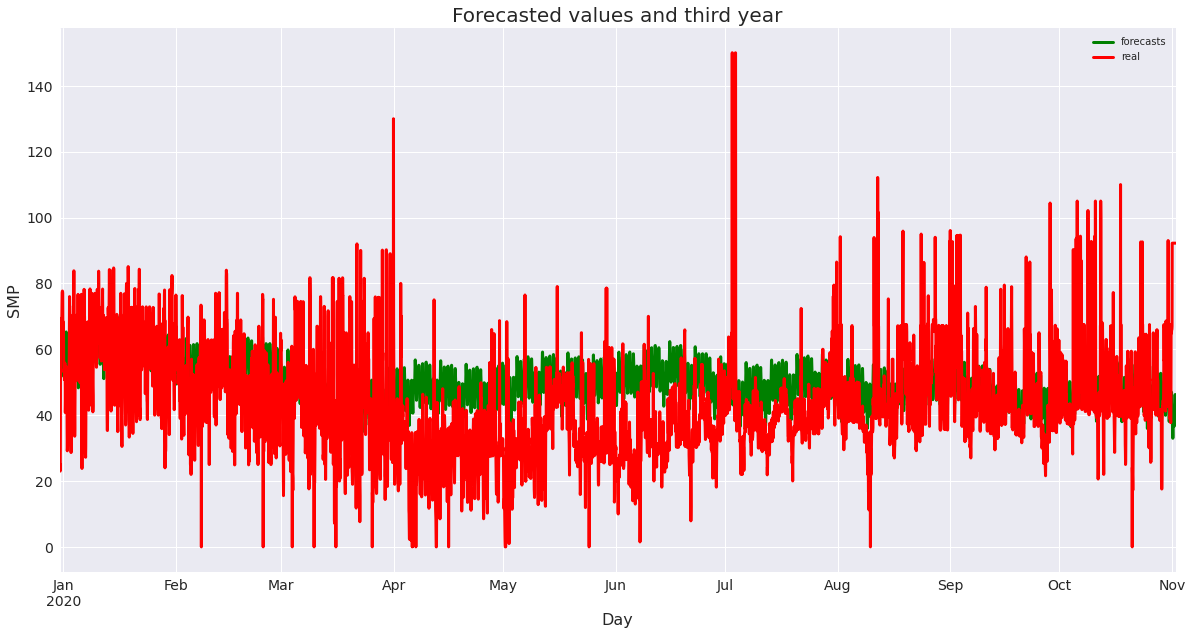

In [65]:
plot_time_series_with_forecasts(frame_2,'Forecasted values and third year')

Text(0, 0.5, 'SMP value')

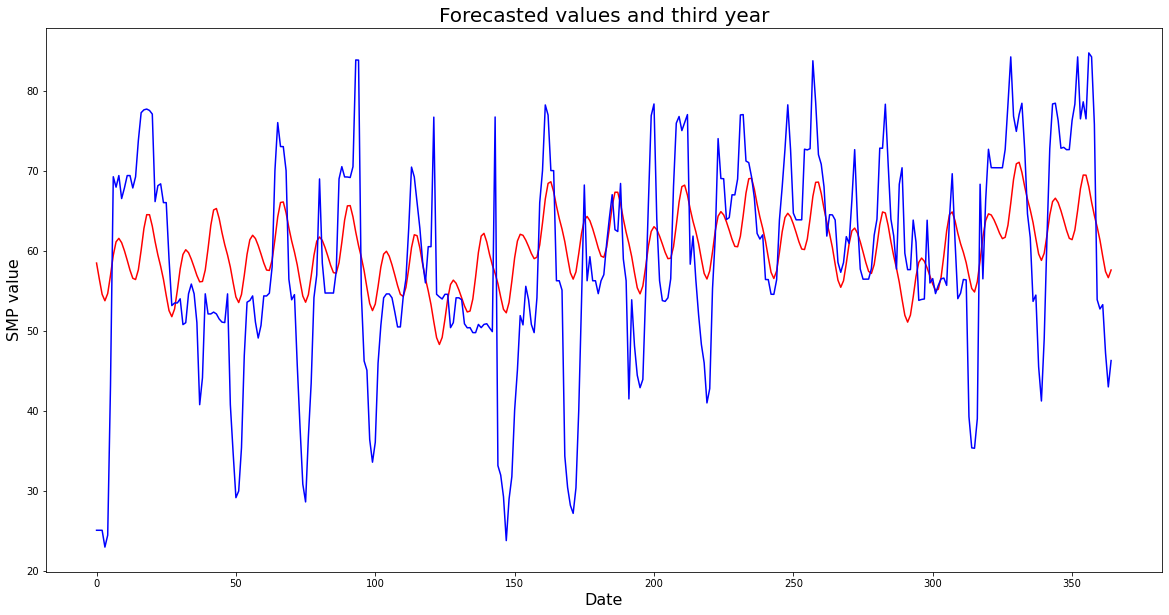

In [39]:
forecasts = auto_forecast.yhat.to_numpy()
real = test_df[['y']].to_numpy()
plt.plot(forecasts[:365], color='red')
plt.plot(real[:365],  color='blue')
plt.rcParams["figure.figsize"] = (20,10)

plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

Long term prediction with auto config of prophet model 1000 hours

In [56]:
test_df,df_predict = init_Test_df_for_prophet(third_year[:1000])

In [57]:
auto_forecast_1000 = auto_model.predict(df_predict)
auto_forecast_1000.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2020-01-01 01:00:00  56.068280   46.142832   67.208742    56.068280   
1 2020-01-01 02:00:00  56.066536   43.007971   64.307717    56.066536   
2 2020-01-01 03:00:00  56.064793   41.098641   62.877320    56.064793   
3 2020-01-01 04:00:00  56.063050   41.854651   62.204117    56.063050   
4 2020-01-01 05:00:00  56.061307   41.877486   62.582838    56.061307   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    56.068280        0.200233              0.200233              0.200233   
1    56.066536       -1.822659             -1.822659             -1.822659   
2    56.064793       -3.696806             -3.696806             -3.696806   
3    56.063050       -4.446961             -4.446961             -4.446961   
4    56.061307       -3.468453             -3.468453             -3.468453   

      daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0 -1.621205  ...  0.420598      0.420598      0.420598  1.400840   
1 -3.620228  ...  0.382607      0.382607      0.382607  1.414962   
2 -5.482124  ...  0.356152      0.356152      0.356152  1.429167   
3 -6.231611  ...  0.341196      0.341196      0.341196  1.443454   
4 -5.263839  ...  0.337563      0.337563      0.337563  1.457823   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      1.400840      1.400840                   0.0   
1      1.414962      1.414962                   0.0   
2      1.429167      1.429167                   0.0   
3      1.443454      1.443454                   0.0   
4      1.457823      1.457823                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  56.268513  
1                         0.0                         0.0  54.243877  
2                         0.0                         0.0  52.367988  
3                         0.0                         0.0  51.616089  
4                         0.0                         0.0  52.592854  

[5 rows x 22 columns]

In [58]:
long_term_metrics.loc['prophet_auto_1000'] = calculate_metrics(test_df[['y']],auto_forecast_1000.yhat)
long_term_metrics


Test MSE: 98.84426
Test RMSE: 9.94205
Test MAPE: inf
Test sMAPE: 19145.05846
Test MAE: 7.61777
Test MARNE: 12387.22708


MSE       RMSE  MAPE  \
SARIMAX_WITH_FOURIER_OPT_LONG_1000  138.439752  11.766042   inf   
SARIMAX_WITH_FOURIER_OPT_LONG_7343  432.780954  20.803388   inf   
prophet_auto                        224.047254  14.968208   inf   
prophet_auto_1000                    98.844262   9.942045   inf   

                                            sMAPE        MAE         MARNE  
SARIMAX_WITH_FOURIER_OPT_LONG_1000      17.306710   9.469520     11.126343  
SARIMAX_WITH_FOURIER_OPT_LONG_7343      38.296559  17.739782     11.822580  
prophet_auto                        234989.651807  11.667994  68550.817850  
prophet_auto_1000                    19145.058462   7.617768  12387.227083

Text(0, 0.5, 'SMP value')

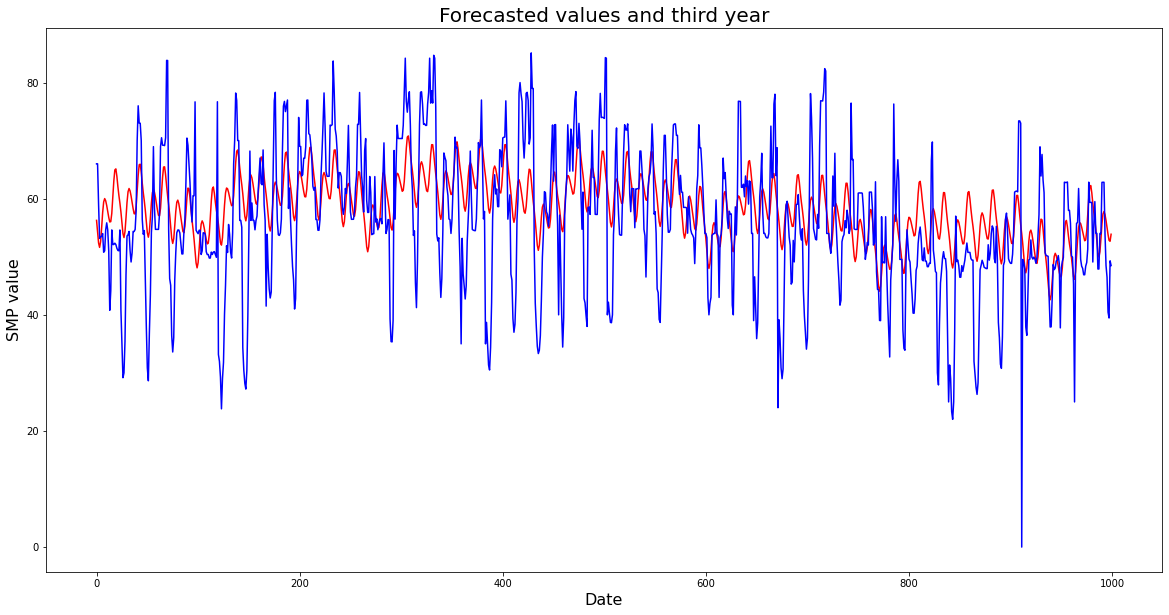

In [112]:
forecasts = auto_forecast_1000.yhat.to_numpy()
real = test_df[['y']].to_numpy()
plt.plot(forecasts, color='red')
plt.plot(real,  color='blue')
plt.rcParams["figure.figsize"] = (20,10)

plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

Text(0, 0.5, 'SMP value')

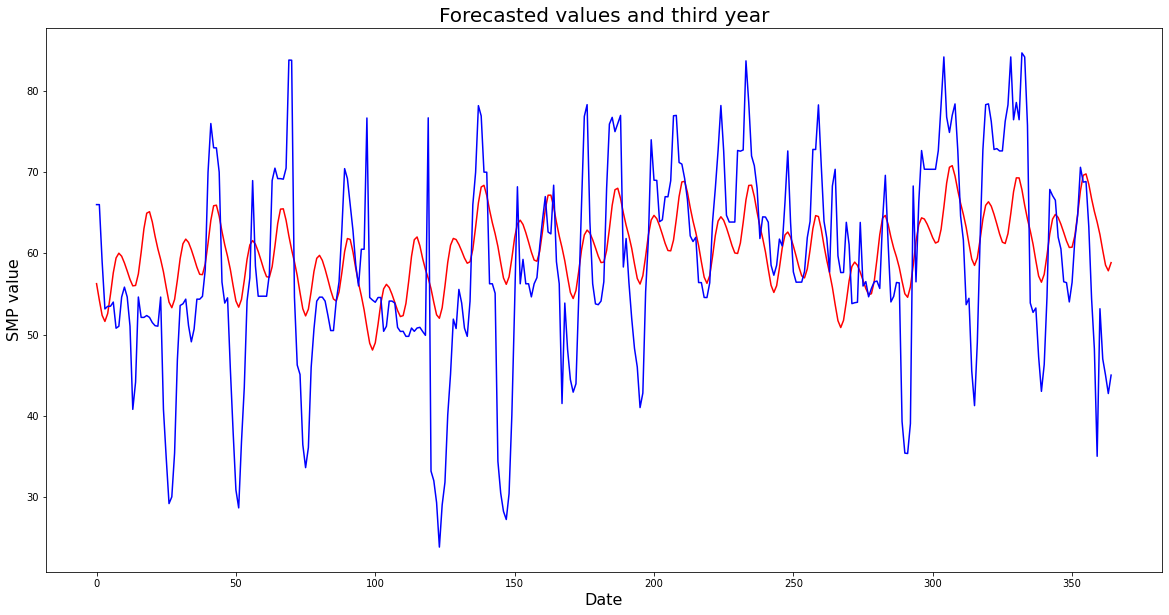

In [111]:
forecasts = auto_forecast_1000.yhat.to_numpy()
real = test_df[['y']].to_numpy()
plt.plot(forecasts[:365], color='red')
plt.plot(real[:365],  color='blue')
plt.rcParams["figure.figsize"] = (20,10)

plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

trying to train manual model with current seasonalities

In [59]:
manual_model = Prophet()
manual_model.add_seasonality(name='daily', period = 12, fourier_order = 15, prior_scale=20)
manual_model.add_seasonality(name='weekly', period = 49*168, fourier_order = 15, prior_scale=20)
manual_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


In [60]:
test_df,df_predict = init_Test_df_for_prophet(third_year[:168])

In [61]:
manual_forecast = manual_model.predict(df_predict)
manual_forecast.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2020-01-01 01:00:00  230.979501   45.193208   68.060936   230.979501   
1 2020-01-01 02:00:00  230.992178   44.568168   67.920229   230.992178   
2 2020-01-01 03:00:00  231.004854   43.778097   67.168421   231.004854   
3 2020-01-01 04:00:00  231.017531   43.475829   66.888066   231.017531   
4 2020-01-01 05:00:00  231.030207   42.753161   65.576751   231.030207   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   230.979501     -174.302407           -174.302407           -174.302407   
1   230.992178     -175.118802           -175.118802           -175.118802   
2   231.004854     -175.783695           -175.783695           -175.783695   
3   231.017531     -176.253188           -176.253188           -176.253188   
4   231.030207     -176.497311           -176.497311           -176.497311   

      daily  daily_lower  daily_upper      weekly  weekly_lower  weekly_upper  \
0 -1.101693    -1.101693    -1.101693 -173.200714   -173.200714   -173.200714   
1 -1.906283    -1.906283    -1.906283 -173.212520   -173.212520   -173.212520   
2 -2.559375    -2.559375    -2.559375 -173.224321   -173.224321   -173.224321   
3 -3.017071    -3.017071    -3.017071 -173.236117   -173.236117   -173.236117   
4 -3.249401    -3.249401    -3.249401 -173.247909   -173.247909   -173.247909   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  56.677094  
1                         0.0  55.873375  
2                         0.0  55.221159  
3                         0.0  54.764343  
4                         0.0  54.532896

Lets check prophet metrics for short predictions with manual model

In [62]:
short_term_metrics.loc['prophet_manual_short'] = calculate_metrics(test_df[['y']],manual_forecast.yhat)
short_term_metrics

Test MSE: 137.94513
Test RMSE: 11.74500
Test MAPE: 21.81685
Test sMAPE: 3069.10653
Test MAE: 8.84516
Test MARNE: 1916.36506


MSE       RMSE       MAPE        sMAPE  \
SARIMAX_WITH_FOURIER_SHORT  146.530240  12.104968  21.895665    19.302929   
prophet_manual_short        137.945125  11.745004  21.816849  3069.106525   

                                  MAE        MARNE  
SARIMAX_WITH_FOURIER_SHORT  10.205541    12.175545  
prophet_manual_short         8.845162  1916.365058

Lets check prophet metrics for short predictions with auto model

In [63]:
short_forecast = auto_model.predict(df_predict)
short_forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2020-01-01 01:00:00  56.068280   46.160986   66.602320    56.068280   
1 2020-01-01 02:00:00  56.066536   43.534277   64.504013    56.066536   
2 2020-01-01 03:00:00  56.064793   42.676957   62.991961    56.064793   
3 2020-01-01 04:00:00  56.063050   41.197200   61.458187    56.063050   
4 2020-01-01 05:00:00  56.061307   41.733632   61.942896    56.061307   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    56.068280        0.200233              0.200233              0.200233   
1    56.066536       -1.822659             -1.822659             -1.822659   
2    56.064793       -3.696806             -3.696806             -3.696806   
3    56.063050       -4.446961             -4.446961             -4.446961   
4    56.061307       -3.468453             -3.468453             -3.468453   

      daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0 -1.621205  ...  0.420598      0.420598      0.420598  1.400840   
1 -3.620228  ...  0.382607      0.382607      0.382607  1.414962   
2 -5.482124  ...  0.356152      0.356152      0.356152  1.429167   
3 -6.231611  ...  0.341196      0.341196      0.341196  1.443454   
4 -5.263839  ...  0.337563      0.337563      0.337563  1.457823   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      1.400840      1.400840                   0.0   
1      1.414962      1.414962                   0.0   
2      1.429167      1.429167                   0.0   
3      1.443454      1.443454                   0.0   
4      1.457823      1.457823                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  56.268513  
1                         0.0                         0.0  54.243877  
2                         0.0                         0.0  52.367988  
3                         0.0                         0.0  51.616089  
4                         0.0                         0.0  52.592854  

[5 rows x 22 columns]

In [64]:
short_term_metrics.loc['prophet_auto_short'] = calculate_metrics(test_df[['y']],short_forecast.yhat)
short_term_metrics

Test MSE: 133.44753
Test RMSE: 11.55195
Test MAPE: 23.87963
Test sMAPE: 3319.79385
Test MAE: 9.04204
Test MARNE: 2102.99685


MSE       RMSE       MAPE        sMAPE  \
SARIMAX_WITH_FOURIER_SHORT  146.530240  12.104968  21.895665    19.302929   
prophet_manual_short        137.945125  11.745004  21.816849  3069.106525   
prophet_auto_short          133.447527  11.551949  23.879629  3319.793855   

                                  MAE        MARNE  
SARIMAX_WITH_FOURIER_SHORT  10.205541    12.175545  
prophet_manual_short         8.845162  1916.365058  
prophet_auto_short           9.042043  2102.996845

It is obvious that we had much better metrics in short term prediction

In [35]:
forecasts= pd.Series(short_forecast.yhat,  name = 'Forecasts')
real= pd.Series(test_df['y'].to_numpy(),  name = 'Real')
dates=pd.Series(test_df['ds'],  name = 'date')
frame_3 = pd.DataFrame({'Dates':dates, 'Forecasts':forecasts, 'Real':real[:168]})
frame_3.set_index("Dates", inplace=True)

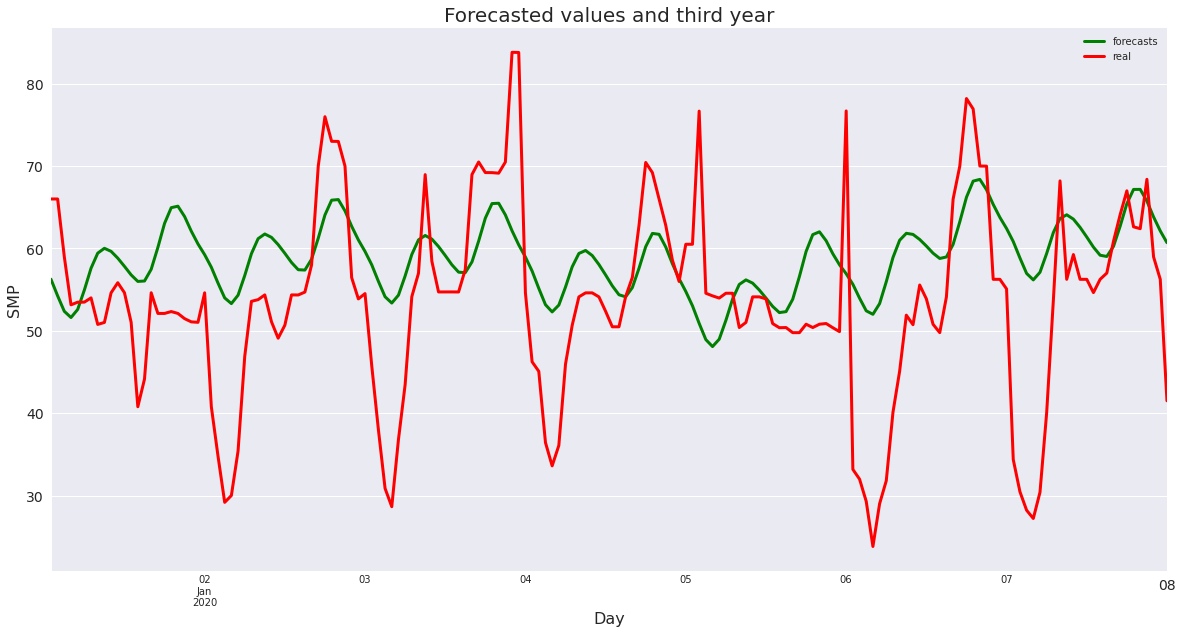

In [38]:
plot_time_series_with_forecasts(frame_3,'Forecasted values and third year')

Text(0, 0.5, 'SMP value')

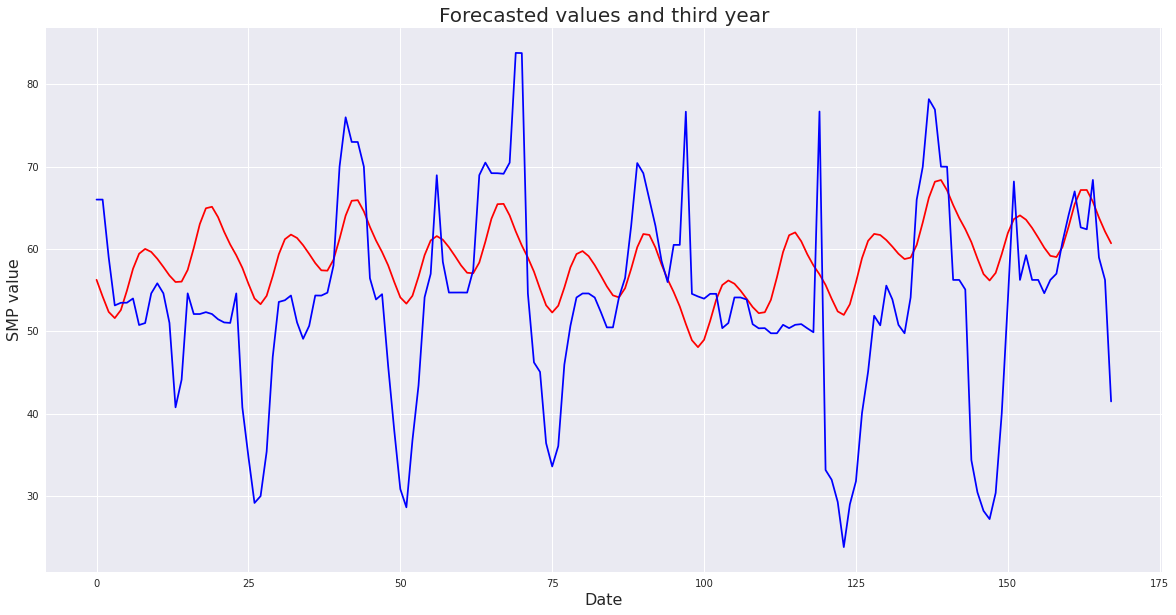

In [40]:
forecasts = short_forecast.yhat.to_numpy()
real = test_df[['y']].to_numpy()
plt.plot(forecasts, color='red')
plt.plot(real[:168],  color='blue')
plt.rcParams["figure.figsize"] = (20,10)

plt.title('Forecasted values and third year', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [65]:
short_term_metrics.to_excel('short_term_prediction.xlsx', header=True)

In [66]:
long_term_metrics.to_excel('long_term_prediction.xlsx', header=True)

In [20]:
#method that replaces zero or negative values with daily average
def replace_zero_negative_values(dataframe):
    dataframe['SMPS'][dataframe['SMPS']<=0] =dataframe['Daily_Average_SMP']
    print('Zero or negative values',sum(series['SMPS']<=0))
    return dataframe

## 5. Model evaluation

It's time to compare metrics

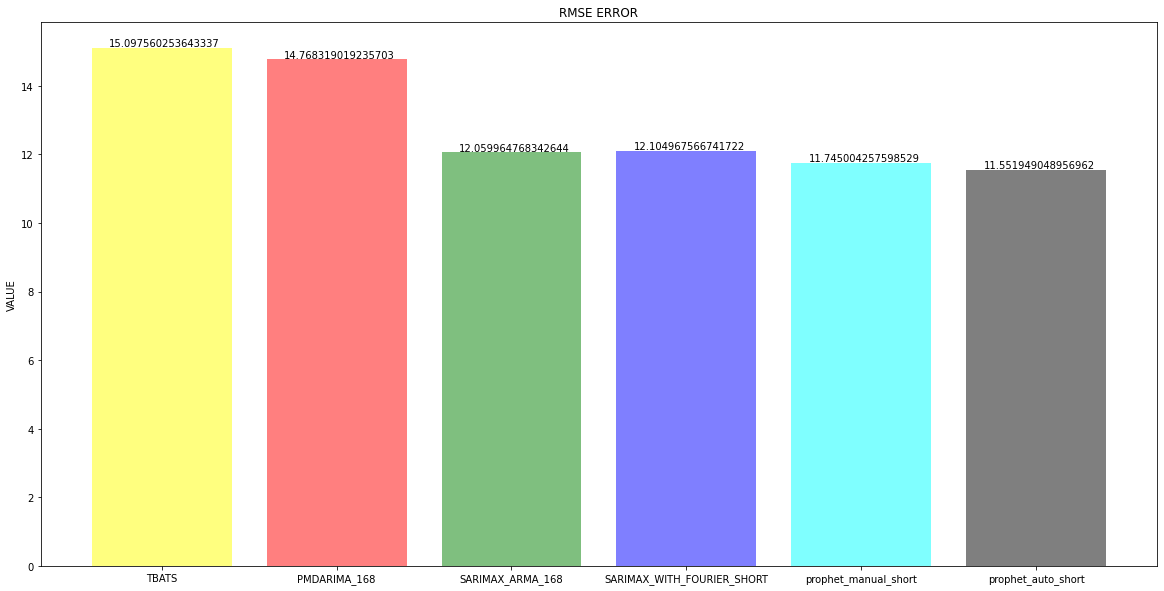

In [119]:
objects = short_term_metrics.index
y_pos = np.arange(len(objects))
performance = short_term_metrics['RMSE']

plt.bar(y_pos, performance, align='center', alpha=0.5,color=['yellow', 'red', 'green', 'blue', 'cyan','black'])
plt.xticks(y_pos, objects)
plt.ylabel('VALUE')
plt.title('RMSE ERROR')
for index, value in enumerate(performance):
    plt.text(index-0.3,value+0.05, str(value))
plt.show()

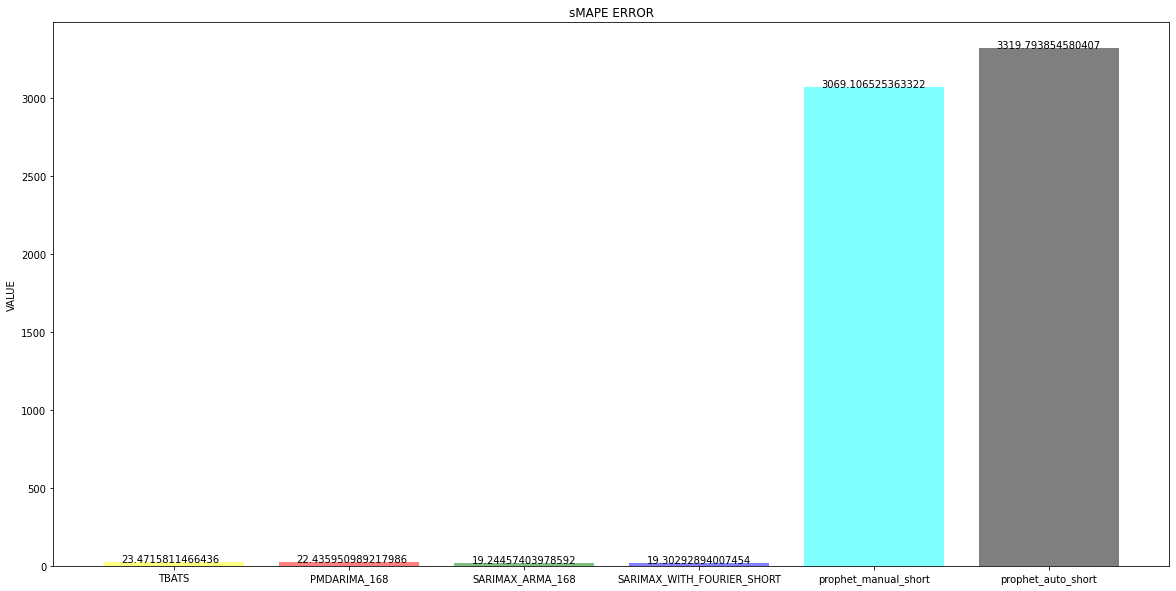

In [120]:
objects = short_term_metrics.index
y_pos = np.arange(len(objects))
performance = short_term_metrics['sMAPE']

plt.bar(y_pos, performance, align='center', alpha=0.5,color=['yellow', 'red', 'green', 'blue', 'cyan','black'])
plt.xticks(y_pos, objects)
plt.ylabel('VALUE')
plt.title('sMAPE ERROR')
for index, value in enumerate(performance):
    plt.text(index-0.3,value+0.05, str(value))
plt.show()

In [126]:
short_term_metrics['MAE']

TBATS                         12.798063
PMDARIMA_168                  12.129010
SARIMAX_ARMA_168              10.157102
SARIMAX_WITH_FOURIER_SHORT    10.205541
prophet_manual_short           8.845162
prophet_auto_short             9.042043
Name: MAE, dtype: float64

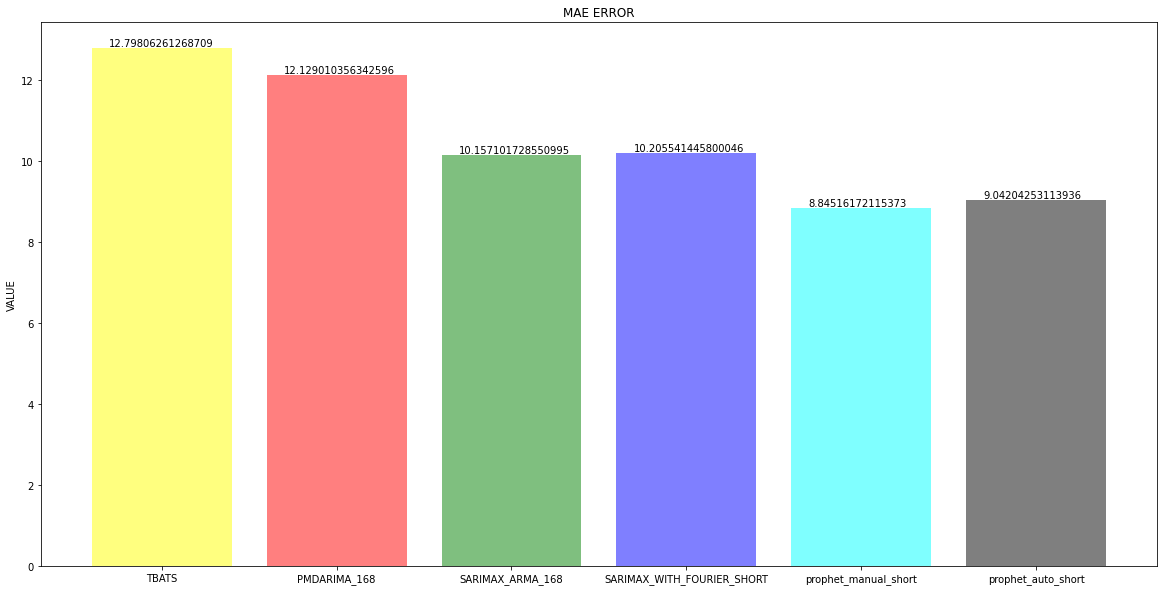

In [129]:
objects = short_term_metrics.index
y_pos = np.arange(len(objects))
performance = short_term_metrics['MAE']

plt.bar(y_pos, performance, align='center', alpha=0.5,color=['yellow', 'red', 'green', 'blue', 'cyan','black'])
plt.xticks(y_pos, objects)
plt.ylabel('VALUE')
plt.title('ΜΑΕ ERROR')
for index, value in enumerate(performance):
    plt.text(index-0.3,value+0.05, str(value))
plt.show()

now long term metrics

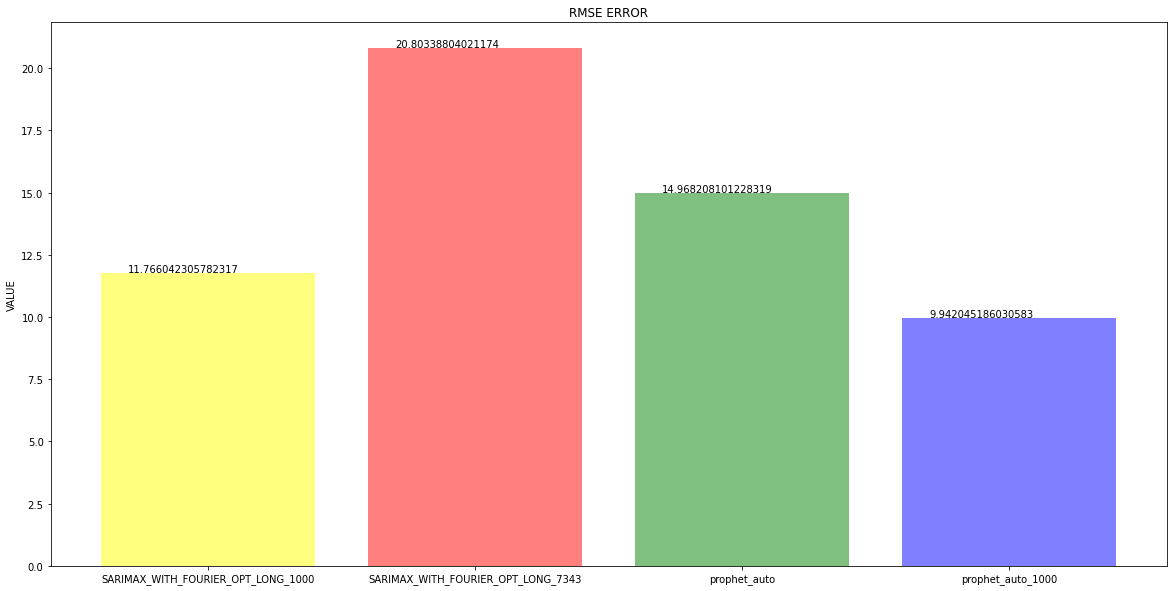

In [134]:
objects = long_term_metrics.index
y_pos = np.arange(len(objects))
performance = long_term_metrics['RMSE']

plt.bar(y_pos, performance, align='center', alpha=0.5,color=['yellow', 'red', 'green', 'blue', 'cyan','black'])
plt.xticks(y_pos, objects)
plt.ylabel('VALUE')
plt.title('RMSE ERROR')
for index, value in enumerate(performance):
    plt.text(index-0.3,value+0.05, str(value))
plt.show()

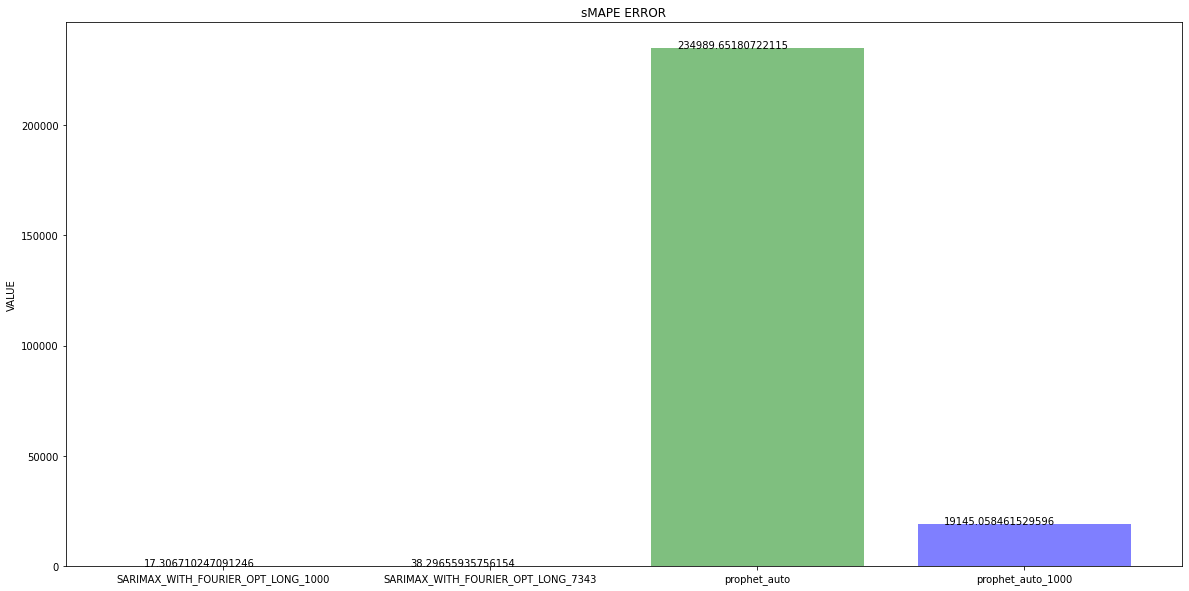

In [135]:
objects = long_term_metrics.index
y_pos = np.arange(len(objects))
performance = long_term_metrics['sMAPE']

plt.bar(y_pos, performance, align='center', alpha=0.5,color=['yellow', 'red', 'green', 'blue', 'cyan','black'])
plt.xticks(y_pos, objects)
plt.ylabel('VALUE')
plt.title('sMAPE ERROR')
for index, value in enumerate(performance):
    plt.text(index-0.3,value+0.05, str(value))
plt.show()

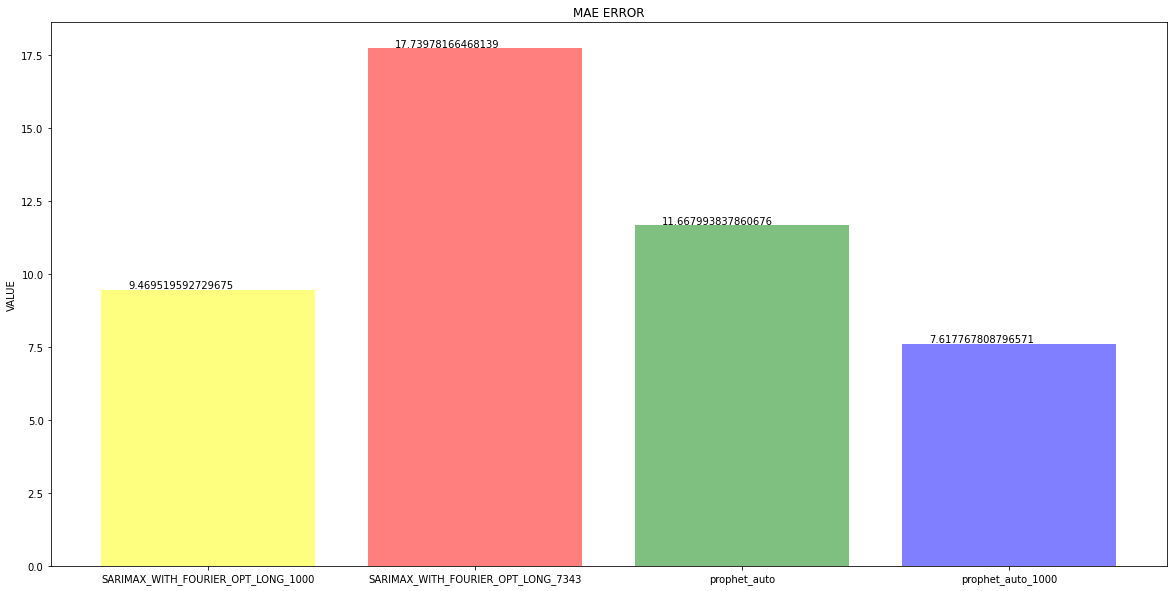

In [136]:
objects = long_term_metrics.index
y_pos = np.arange(len(objects))
performance = long_term_metrics['MAE']

plt.bar(y_pos, performance, align='center', alpha=0.5,color=['yellow', 'red', 'green', 'blue', 'cyan','black'])
plt.xticks(y_pos, objects)
plt.ylabel('VALUE')
plt.title('ΜΑΕ ERROR')
for index, value in enumerate(performance):
    plt.text(index-0.3,value+0.05, str(value))
plt.show()

we calculate bias for the two prophet models to decide which metric we should take mostly account

In [170]:
def mbe(predicted,actual):
    actual = actual if isinstance(actual,(np.ndarray)) else actual[:len(predicted)].to_numpy()
    predicted = predicted if isinstance(predicted,(np.ndarray)) else predicted.to_numpy()
    return 1/len(actual) * np.sum(predicted - actual)

In [167]:
test_df,df_predict = init_Test_df_for_prophet(third_year[:168])

In [173]:
mbe_auto=mbe(short_forecast.yhat,test_df[['y']])
mbe_auto

873.9574248843056

In [174]:
mbe_manual=mbe(manual_forecast.yhat,test_df[['y']])
mbe_manual

679.4936303862695

In [175]:
long_term_metrics

MSE       RMSE          sMAPE  \
SARIMAX_WITH_FOURIER_OPT_LONG_1000  138.439752  11.766042      17.306710   
SARIMAX_WITH_FOURIER_OPT_LONG_7343  432.780954  20.803388      38.296559   
prophet_auto                        224.047254  14.968208  234989.651807   
prophet_auto_1000                    98.844262   9.942045   19145.058462   

                                          MAE  
SARIMAX_WITH_FOURIER_OPT_LONG_1000   9.469520  
SARIMAX_WITH_FOURIER_OPT_LONG_7343  17.739782  
prophet_auto                        11.667994  
prophet_auto_1000                    7.617768

## 6. Real predictions 

Short term 

In [17]:
train_df = init_Training_df_for_prophet(full_df)
train_df

ds       y  Daily_Average_SMP
0     2018-01-01 00:00:00  57.883          52.852167
1     2018-01-01 01:00:00  58.088          52.852167
2     2018-01-01 02:00:00  57.959          52.852167
3     2018-01-01 03:00:00  54.575          52.852167
4     2018-01-01 04:00:00  54.470          52.852167
...                   ...     ...                ...
24883 2020-11-01 19:00:00  92.223          92.223000
24884 2020-11-01 20:00:00  92.223          92.223000
24885 2020-11-01 21:00:00  92.223          92.223000
24886 2020-11-01 22:00:00  92.223          92.223000
24887 2020-11-01 23:00:00  92.223          92.223000

[24888 rows x 3 columns]

In [18]:
manual_model = Prophet()
manual_model.add_seasonality(name='daily', period = 12, fourier_order = 15, prior_scale=20)
manual_model.add_seasonality(name='weekly', period = 49*168, fourier_order = 15, prior_scale=20)
manual_model.fit(train_df)

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


In [19]:
def create_future_dataframe(df,offset):
    last_index=df.index[-1]
    last_date = df['ds'].loc[last_index]
    print('Last date in training df:',last_date)
    future_dates = pd.date_range(start=(last_date+timedelta(hours = 1)), end=(last_date+timedelta(hours = offset)), freq='H')
    future_dataframe = pd.DataFrame(future_dates,columns =['ds'])
    final_df =df.append(future_dataframe)
    return final_df

In [20]:
future_dataframe = create_future_dataframe(train_df,24)
future_dataframe

Last date in training df: 2020-11-01 23:00:00


ds       y  Daily_Average_SMP
0  2018-01-01 00:00:00  57.883          52.852167
1  2018-01-01 01:00:00  58.088          52.852167
2  2018-01-01 02:00:00  57.959          52.852167
3  2018-01-01 03:00:00  54.575          52.852167
4  2018-01-01 04:00:00  54.470          52.852167
..                 ...     ...                ...
19 2020-11-02 19:00:00     NaN                NaN
20 2020-11-02 20:00:00     NaN                NaN
21 2020-11-02 21:00:00     NaN                NaN
22 2020-11-02 22:00:00     NaN                NaN
23 2020-11-02 23:00:00     NaN                NaN

[24912 rows x 3 columns]

In [21]:
one_day_ahead_forecast = manual_model.predict(future_dataframe)
one_day_ahead_forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2018-01-01 00:00:00  59.887258   37.539550   64.213937    59.887258   
1     2018-01-01 01:00:00  59.887526   37.008496   62.110220    59.887526   
2     2018-01-01 02:00:00  59.887794   36.788937   62.401038    59.887794   
3     2018-01-01 03:00:00  59.888061   36.088709   61.761292    59.888061   
4     2018-01-01 04:00:00  59.888329   35.837644   60.605417    59.888329   
...                   ...        ...         ...         ...          ...   
24907 2020-11-02 19:00:00  21.131183   33.307371   60.568756    21.131183   
24908 2020-11-02 20:00:00  21.123417   34.354645   60.282062    21.123417   
24909 2020-11-02 21:00:00  21.115651   34.397917   60.526576    21.115651   
24910 2020-11-02 22:00:00  21.107885   34.786359   59.722956    21.107885   
24911 2020-11-02 23:00:00  21.100119   32.227720   58.718013    21.100119   

       trend_upper  additive_terms  additive_terms_lower  \
0        59.887258       -8.974923             -8.974923   
1        59.887526       -9.765729             -9.765729   
2        59.887794      -10.518760            -10.518760   
3        59.888061      -11.183633            -11.183633   
4        59.888329      -11.716790            -11.716790   
...            ...             ...                   ...   
24907    21.131183       26.204303             26.204303   
24908    21.123417       26.157626             26.157626   
24909    21.115651       25.903041             25.903041   
24910    21.107885       25.462594             25.462594   
24911    21.100119       24.870726             24.870726   

       additive_terms_upper     daily  ...     weekly  weekly_lower  \
0                 -8.974923 -0.035879  ... -18.463435    -18.463435   
1                 -9.765729 -0.835470  ... -18.469702    -18.469702   
2                -10.518760 -1.597373  ... -18.475955    -18.475955   
3                -11.183633 -2.271204  ... -18.482195    -18.482195   
4                -11.716790 -2.813405  ... -18.488423    -18.488423   
...                     ...       ...  ...        ...           ...   
24907             26.204303  3.126922  ...  21.734029     21.734029   
24908             26.157626  3.094655  ...  21.725193     21.725193   
24909             25.903041  2.854481  ...  21.716342     21.716342   
24910             25.462594  2.428446  ...  21.707474     21.707474   
24911             24.870726  1.850990  ...  21.698590     21.698590   

       weekly_upper    yearly  yearly_lower  yearly_upper  \
0        -18.463435  9.524391      9.524391      9.524391   
1        -18.469702  9.539443      9.539443      9.539443   
2        -18.475955  9.554568      9.554568      9.554568   
3        -18.482195  9.569766      9.569766      9.569766   
4        -18.488423  9.585038      9.585038      9.585038   
...             ...       ...           ...           ...   
24907     21.734029  1.343352      1.343352      1.343352   
24908     21.725193  1.337778      1.337778      1.337778   
24909     21.716342  1.332219      1.332219      1.332219   
24910     21.707474  1.326674      1.326674      1.326674   
24911     21.698590  1.321145      1.321145      1.321145   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
24907                   0.0                         0.0   
24908                   0.0                         0.0   
24909                   0.0                         0.0   
24910                   0.0                         0.0   
24911                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
0                             0.0  

Text(0, 0.5, 'SMP value')

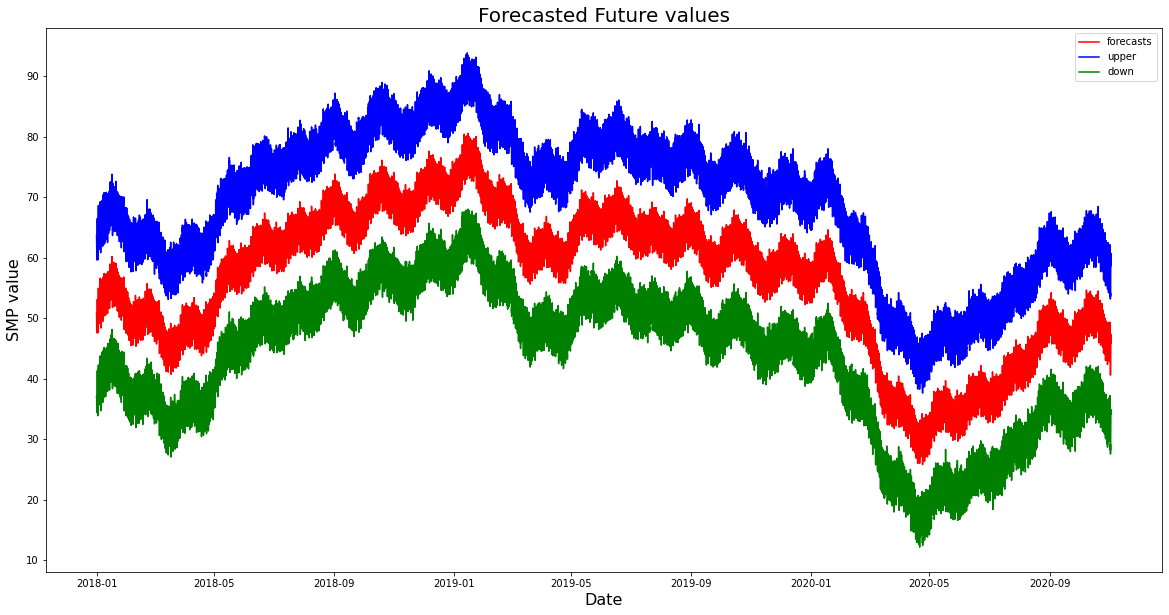

In [75]:
forecasts = one_day_ahead_forecast.yhat.to_numpy()
upper= one_day_ahead_forecast.yhat_upper.to_numpy()
down = one_day_ahead_forecast.yhat_lower.to_numpy()
plt.plot(future_dataframe['ds'],forecasts, color='red')
plt.plot(future_dataframe['ds'],upper, color='blue')
plt.plot(future_dataframe['ds'],down, color='green')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(['forecasts','upper','down'])
plt.title('Forecasted Future values', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

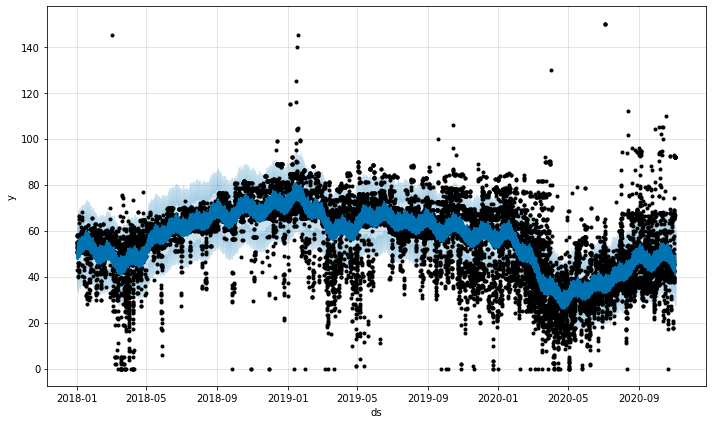

In [36]:
one_day_plot = manual_model.plot(one_day_ahead_forecast)


In [47]:
len(one_day_ahead_forecast)

24912

In [22]:
last_24_hours = one_day_ahead_forecast.yhat[-24:].to_numpy()
last_24_hours

array([45.75599469, 44.69259596, 43.64664477, 42.68085573, 41.85243219,
       41.20929301, 40.78696602, 40.60635218, 40.67250071, 40.9744641 ,
       41.48622677, 42.16862841, 42.97213742, 43.84027546, 44.7134542 ,
       45.53296284, 46.24483961, 46.80337345, 47.1740108 , 47.33548543,
       47.28104294, 47.0186921 , 46.57047923, 45.97084442])

In [27]:
last_24_hours_upper = one_day_ahead_forecast.yhat_upper[-24:].to_numpy()
last_24_hours_lower = one_day_ahead_forecast.yhat_lower[-24:].to_numpy()

Text(0, 0.5, 'SMP value')

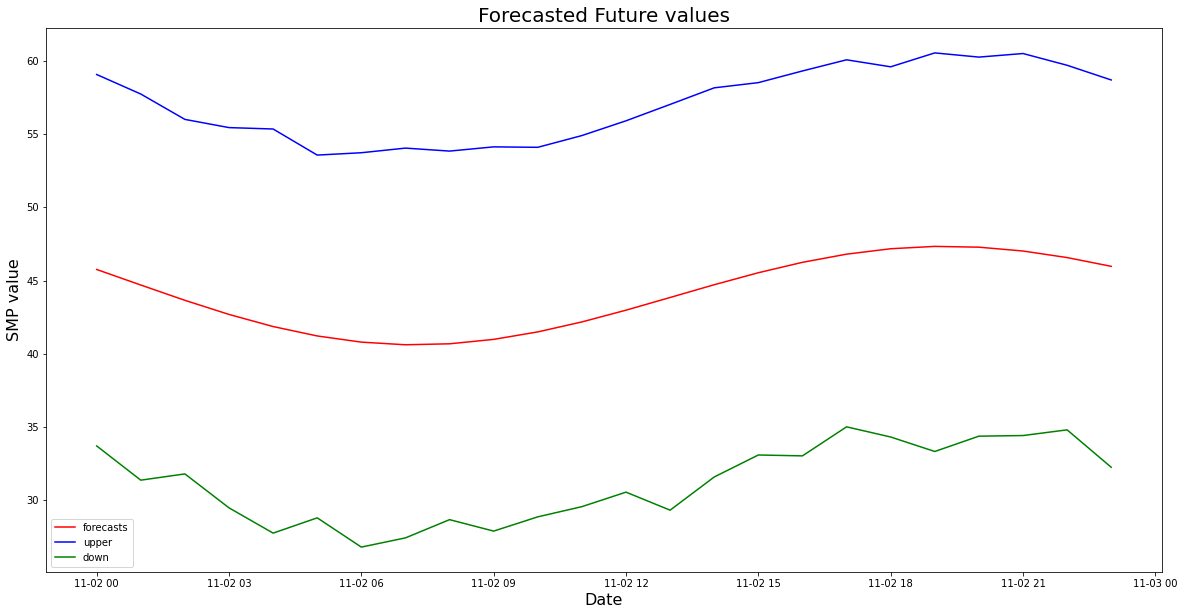

In [29]:
plt.plot(future_dataframe['ds'][-24:],last_24_hours, color='red')
plt.plot(future_dataframe['ds'][-24:],last_24_hours_upper, color='blue')
plt.plot(future_dataframe['ds'][-24:],last_24_hours_lower, color='green')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(['forecasts','upper','down'])

plt.title('Forecasted Future values', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [24]:
from scipy import stats
stats.describe(last_24_hours)


DescribeResult(nobs=24, minmax=(40.60635218082987, 47.335485430090884), mean=44.08293968445048, variance=5.991786583411437, skewness=-0.08655089107118624, kurtosis=-1.518596757010656)

In [25]:
np.var(last_24_hours,ddof=1)

5.991786583411437

In [26]:
np.std(last_24_hours)

2.3962739428334623

168 hours prediction

In [30]:
future_dataframe = create_future_dataframe(train_df,168)
future_dataframe

Last date in training df: 2020-11-01 23:00:00


ds       y  Daily_Average_SMP
0   2018-01-01 00:00:00  57.883          52.852167
1   2018-01-01 01:00:00  58.088          52.852167
2   2018-01-01 02:00:00  57.959          52.852167
3   2018-01-01 03:00:00  54.575          52.852167
4   2018-01-01 04:00:00  54.470          52.852167
..                  ...     ...                ...
163 2020-11-08 19:00:00     NaN                NaN
164 2020-11-08 20:00:00     NaN                NaN
165 2020-11-08 21:00:00     NaN                NaN
166 2020-11-08 22:00:00     NaN                NaN
167 2020-11-08 23:00:00     NaN                NaN

[25056 rows x 3 columns]

In [31]:
one_week_ahead_forecast = manual_model.predict(future_dataframe)
one_week_ahead_forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2018-01-01 00:00:00  59.887258   37.793250   63.936511    59.887258   
1     2018-01-01 01:00:00  59.887526   37.343263   62.922015    59.887526   
2     2018-01-01 02:00:00  59.887794   36.600025   62.666918    59.887794   
3     2018-01-01 03:00:00  59.888061   36.108728   60.489963    59.888061   
4     2018-01-01 04:00:00  59.888329   34.935949   60.627845    59.888329   
...                   ...        ...         ...         ...          ...   
25051 2020-11-08 19:00:00  20.012880   30.501247   56.929332    20.012880   
25052 2020-11-08 20:00:00  20.005114   30.377690   56.467051    20.005114   
25053 2020-11-08 21:00:00  19.997348   30.822184   55.649350    19.997348   
25054 2020-11-08 22:00:00  19.989582   28.487344   54.393344    19.989582   
25055 2020-11-08 23:00:00  19.981816   28.232207   54.125826    19.981816   

       trend_upper  additive_terms  additive_terms_lower  \
0        59.887258       -8.974923             -8.974923   
1        59.887526       -9.765729             -9.765729   
2        59.887794      -10.518760            -10.518760   
3        59.888061      -11.183633            -11.183633   
4        59.888329      -11.716790            -11.716790   
...            ...             ...                   ...   
25051    20.012880       23.716530             23.716530   
25052    20.005114       23.405564             23.405564   
25053    19.997348       22.893864             22.893864   
25054    19.989582       22.213815             22.213815   
25055    19.981816       21.409680             21.409680   

       additive_terms_upper     daily  ...     weekly  weekly_lower  \
0                 -8.974923 -0.035879  ... -18.463435    -18.463435   
1                 -9.765729 -0.835470  ... -18.469702    -18.469702   
2                -10.518760 -1.597373  ... -18.475955    -18.475955   
3                -11.183633 -2.271204  ... -18.482195    -18.482195   
4                -11.716790 -2.813405  ... -18.488423    -18.488423   
...                     ...       ...  ...        ...           ...   
25051             23.716530  2.621754  ...  20.293625     20.293625   
25052             23.405564  2.323185  ...  20.282425     20.282425   
25053             22.893864  1.823853  ...  20.271208     20.271208   
25054             22.213815  1.156144  ...  20.259974     20.259974   
25055             21.409680  0.364321  ...  20.248723     20.248723   

       weekly_upper    yearly  yearly_lower  yearly_upper  \
0        -18.463435  9.524391      9.524391      9.524391   
1        -18.469702  9.539443      9.539443      9.539443   
2        -18.475955  9.554568      9.554568      9.554568   
3        -18.482195  9.569766      9.569766      9.569766   
4        -18.488423  9.585038      9.585038      9.585038   
...             ...       ...           ...           ...   
25051     20.293625  0.801151      0.801151      0.801151   
25052     20.282425  0.799954      0.799954      0.799954   
25053     20.271208  0.798803      0.798803      0.798803   
25054     20.259974  0.797697      0.797697      0.797697   
25055     20.248723  0.796636      0.796636      0.796636   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
25051                   0.0                         0.0   
25052                   0.0                         0.0   
25053                   0.0                         0.0   
25054                   0.0                         0.0   
25055                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
0                             0.0  

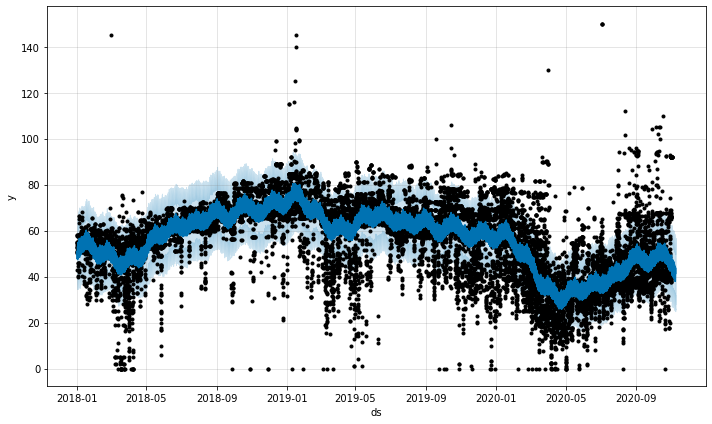

In [57]:
one_week_plot = manual_model.plot(one_week_ahead_forecast)


Text(0, 0.5, 'SMP value')

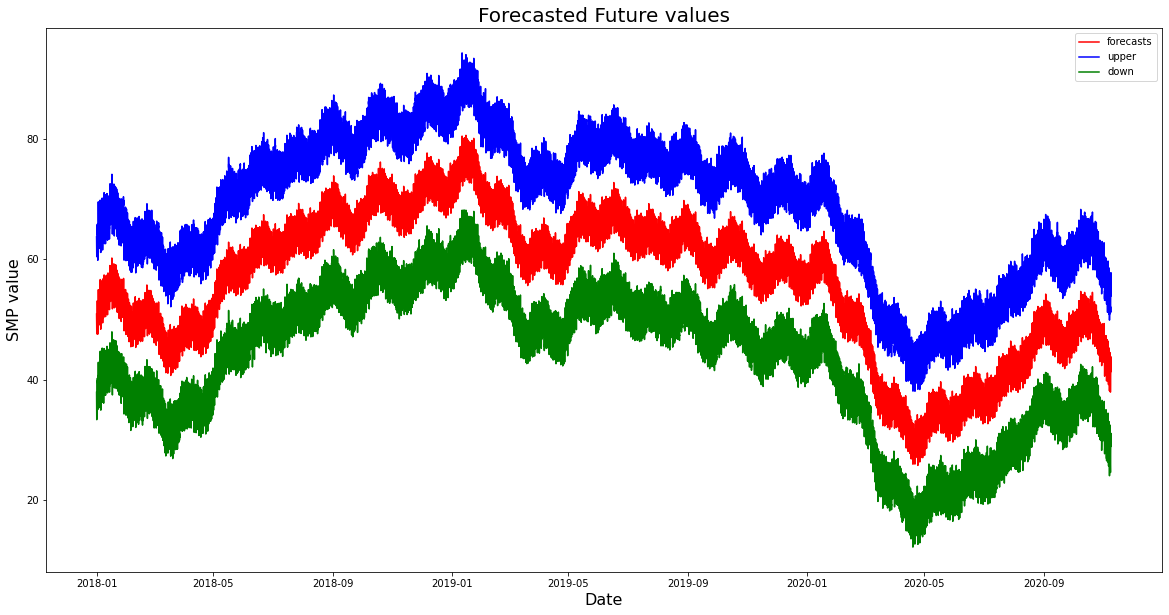

In [79]:
forecasts = one_week_ahead_forecast.yhat.to_numpy()
upper= one_week_ahead_forecast.yhat_upper.to_numpy()
down = one_week_ahead_forecast.yhat_lower.to_numpy()
plt.plot(future_dataframe['ds'],forecasts, color='red')
plt.plot(future_dataframe['ds'],upper, color='blue')
plt.plot(future_dataframe['ds'],down, color='green')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(['forecasts','upper','down'])
plt.title('Forecasted Future values', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [34]:
last_week = one_week_ahead_forecast.yhat[-168:].to_numpy()
last_week

array([45.75599469, 44.69259596, 43.64664477, 42.68085573, 41.85243219,
       41.20929301, 40.78696602, 40.60635218, 40.67250071, 40.9744641 ,
       41.48622677, 42.16862841, 42.97213742, 43.84027546, 44.7134542 ,
       45.53296284, 46.24483961, 46.80337345, 47.1740108 , 47.33548543,
       47.28104294, 47.0186921 , 46.57047923, 45.97084442, 45.2641764 ,
       44.50173265, 43.73812969, 43.02763431, 42.42049683, 41.95956392,
       41.67738947, 41.59403023, 41.7156693 , 42.03415857, 42.52751272,
       43.16132744, 43.89103476, 44.66485441, 45.42725347, 46.12269166,
       46.69940762, 47.11299559, 47.32953117, 47.32803031, 47.10206606,
       46.66042032, 46.02670976, 45.23799353, 44.34243925, 43.39618989,
       42.45963213, 41.59331247, 40.85377765, 40.28962691, 39.93805563,
       39.82214125, 39.94907546, 40.30948376, 40.87789915, 41.61437521,
       42.46714228, 43.37613288, 44.27713709, 45.10629845, 45.80463143,
       46.32223474, 46.62189239, 46.68179431, 46.49716988, 46.08

In [32]:
last_week_upper = one_day_ahead_forecast.yhat_upper[-168:].to_numpy()
last_week_lower = one_day_ahead_forecast.yhat_lower[-168:].to_numpy()

Text(0, 0.5, 'SMP value')

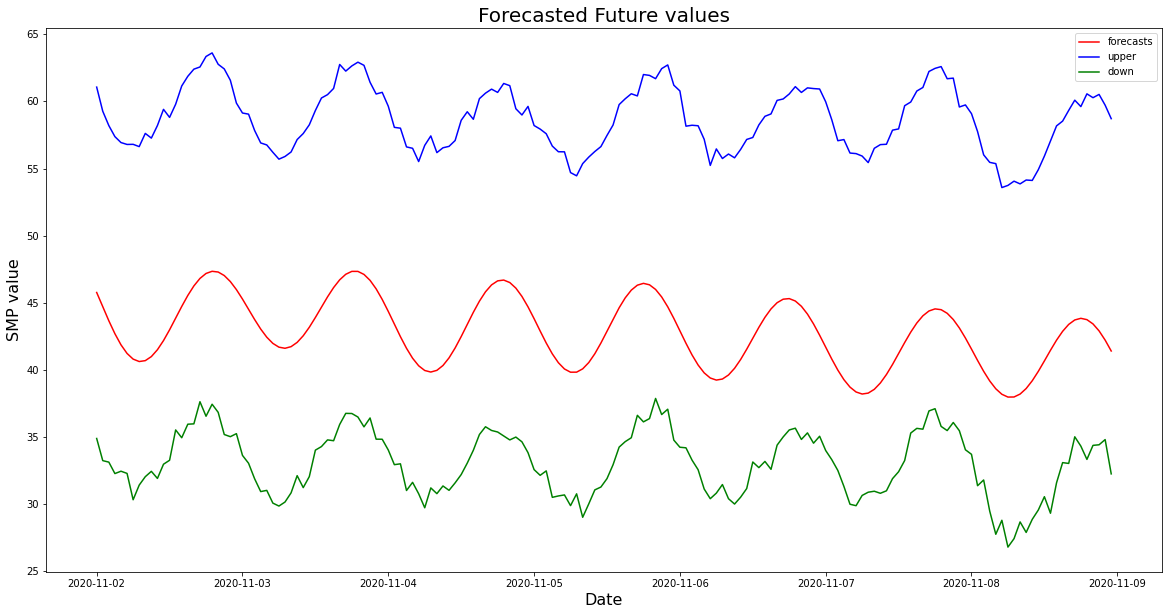

In [37]:
plt.plot(future_dataframe['ds'][-168:],last_week, color='red')
plt.plot(future_dataframe['ds'][-168:],last_week_upper, color='blue')
plt.plot(future_dataframe['ds'][-168:],last_week_lower, color='green')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(['forecasts','upper','down'])

plt.title('Forecasted Future values', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [34]:
from scipy import stats
stats.describe(last_week)

DescribeResult(nobs=168, minmax=(37.956172387970796, 47.335485430090884), mean=42.79302806169264, variance=6.495954588867495, skewness=-0.01023054384949991, kurtosis=-1.0050265284546969)

In [36]:
np.std(last_week)

2.5411194762358558

long term prediction 1000 hours

In [38]:
train_df = init_Training_df_for_prophet(full_df)
train_df

ds       y  Daily_Average_SMP
0     2018-01-01 00:00:00  57.883          52.852167
1     2018-01-01 01:00:00  58.088          52.852167
2     2018-01-01 02:00:00  57.959          52.852167
3     2018-01-01 03:00:00  54.575          52.852167
4     2018-01-01 04:00:00  54.470          52.852167
...                   ...     ...                ...
24883 2020-11-01 19:00:00  92.223          92.223000
24884 2020-11-01 20:00:00  92.223          92.223000
24885 2020-11-01 21:00:00  92.223          92.223000
24886 2020-11-01 22:00:00  92.223          92.223000
24887 2020-11-01 23:00:00  92.223          92.223000

[24888 rows x 3 columns]

In [39]:
auto_model = Prophet(yearly_seasonality=True)
auto_model.fit(train_df)

In [40]:
last_date=datetime(2020,11,1,23,0)
future_dates = pd.date_range(start=(last_date+timedelta(hours = 1)), end=(last_date+timedelta(hours = 1000)), freq='H')
future_dates

DatetimeIndex(['2020-11-02 00:00:00', '2020-11-02 01:00:00',
               '2020-11-02 02:00:00', '2020-11-02 03:00:00',
               '2020-11-02 04:00:00', '2020-11-02 05:00:00',
               '2020-11-02 06:00:00', '2020-11-02 07:00:00',
               '2020-11-02 08:00:00', '2020-11-02 09:00:00',
               ...
               '2020-12-13 06:00:00', '2020-12-13 07:00:00',
               '2020-12-13 08:00:00', '2020-12-13 09:00:00',
               '2020-12-13 10:00:00', '2020-12-13 11:00:00',
               '2020-12-13 12:00:00', '2020-12-13 13:00:00',
               '2020-12-13 14:00:00', '2020-12-13 15:00:00'],
              dtype='datetime64[ns]', length=1000, freq='H')

In [41]:
future_dataframe = create_future_dataframe(train_df,1000)
future_dataframe

Last date in training df: 2020-11-01 23:00:00


ds       y  Daily_Average_SMP
0   2018-01-01 00:00:00  57.883          52.852167
1   2018-01-01 01:00:00  58.088          52.852167
2   2018-01-01 02:00:00  57.959          52.852167
3   2018-01-01 03:00:00  54.575          52.852167
4   2018-01-01 04:00:00  54.470          52.852167
..                  ...     ...                ...
995 2020-12-13 11:00:00     NaN                NaN
996 2020-12-13 12:00:00     NaN                NaN
997 2020-12-13 13:00:00     NaN                NaN
998 2020-12-13 14:00:00     NaN                NaN
999 2020-12-13 15:00:00     NaN                NaN

[25888 rows x 3 columns]

In [42]:
hours_1000_ahead_forecast = auto_model.predict(future_dataframe)
hours_1000_ahead_forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2018-01-01 00:00:00  43.530013   35.561604   59.870304    43.530013   
1     2018-01-01 01:00:00  43.534871   33.567561   56.581371    43.534871   
2     2018-01-01 02:00:00  43.539729   31.540433   55.495713    43.539729   
3     2018-01-01 03:00:00  43.544588   29.644812   53.913930    43.544588   
4     2018-01-01 04:00:00  43.549446   28.903775   52.448555    43.549446   
...                   ...        ...         ...         ...          ...   
25883 2020-12-13 11:00:00  44.075407   34.542645   58.885307    42.717728   
25884 2020-12-13 12:00:00  44.075896   33.249612   56.950861    42.716689   
25885 2020-12-13 13:00:00  44.076385   32.020727   55.365442    42.715649   
25886 2020-12-13 14:00:00  44.076875   31.396096   55.899230    42.714610   
25887 2020-12-13 15:00:00  44.077364   31.661536   55.845765    42.713571   

       trend_upper  additive_terms  additive_terms_lower  \
0        43.530013        3.201694              3.201694   
1        43.534871        1.584856              1.584856   
2        43.539729       -0.379007             -0.379007   
3        43.544588       -2.138721             -2.138721   
4        43.549446       -2.667415             -2.667415   
...            ...             ...                   ...   
25883    45.612268        2.516898              2.516898   
25884    45.615073        1.351967              1.351967   
25885    45.618007        0.243457              0.243457   
25886    45.621433       -0.563702             -0.563702   
25887    45.624809       -0.481397             -0.481397   

       additive_terms_upper     daily  ...    weekly  weekly_lower  \
0                  3.201694  0.308504  ... -2.837455     -2.837455   
1                  1.584856 -1.597293  ... -2.559744     -2.559744   
2                 -0.379007 -3.859641  ... -2.272576     -2.272576   
3                 -2.138721 -5.925433  ... -1.977888     -1.977888   
4                 -2.667415 -6.765804  ... -1.677671     -1.677671   
...                     ...       ...  ...       ...           ...   
25883              2.516898  0.270654  ... -4.906791     -4.906791   
25884              1.351967 -0.918897  ... -4.874731     -4.874731   
25885              0.243457 -2.074910  ... -4.819745     -4.819745   
25886             -0.563702 -2.952429  ... -4.741857     -4.741857   
25887             -0.481397 -2.963137  ... -4.641273     -4.641273   

       weekly_upper    yearly  yearly_lower  yearly_upper  \
0         -2.837455  5.730645      5.730645      5.730645   
1         -2.559744  5.741892      5.741892      5.741892   
2         -2.272576  5.753211      5.753211      5.753211   
3         -1.977888  5.764600      5.764600      5.764600   
4         -1.677671  5.776060      5.776060      5.776060   
...             ...       ...           ...           ...   
25883     -4.906791  7.153034      7.153034      7.153034   
25884     -4.874731  7.145595      7.145595      7.145595   
25885     -4.819745  7.138111      7.138111      7.138111   
25886     -4.741857  7.130584      7.130584      7.130584   
25887     -4.641273  7.123013      7.123013      7.123013   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
25883                   0.0                         0.0   
25884                   0.0                         0.0   
25885                   0.0                         0.0   
25886                   0.0                         0.0   
25887                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
0                             0.0  46.731707  


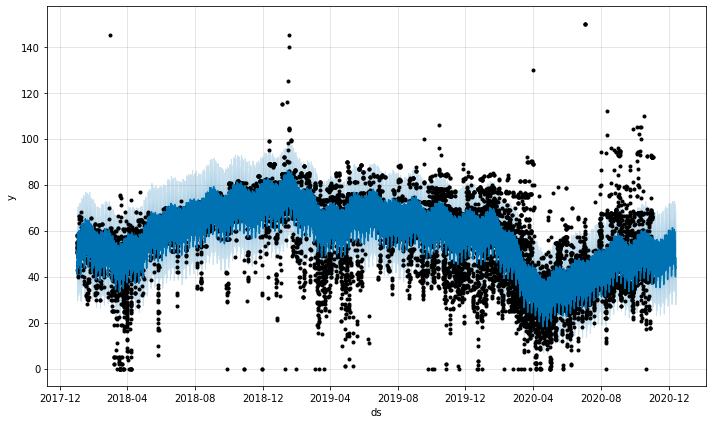

In [42]:
hours_1000_plot = auto_model.plot(hours_1000_ahead_forecast)


Text(0, 0.5, 'SMP value')

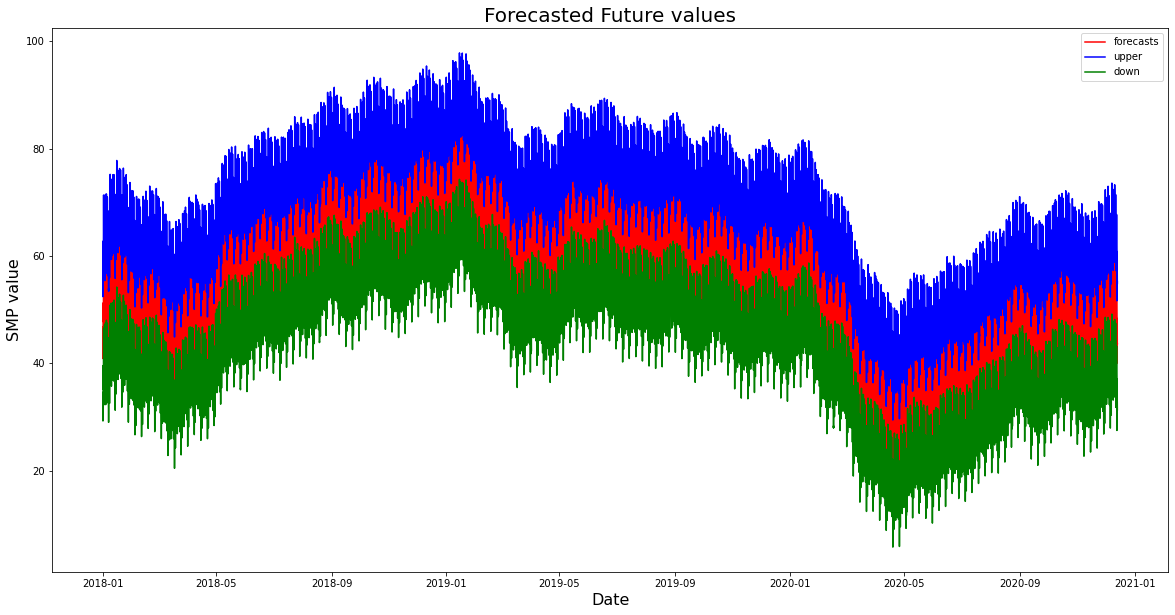

In [86]:
forecasts = hours_1000_ahead_forecast.yhat.to_numpy()
upper= hours_1000_ahead_forecast.yhat_upper.to_numpy()
down = hours_1000_ahead_forecast.yhat_lower.to_numpy()
plt.plot(future_dataframe['ds'],forecasts, color='red')
plt.plot(future_dataframe['ds'],upper, color='blue')
plt.plot(future_dataframe['ds'],down, color='green')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(['forecasts','upper','down'])
plt.title('Forecasted Future values', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [44]:
last_1000_hours = hours_1000_ahead_forecast.yhat[-1000:].to_numpy()
last_1000_hours

array([45.1969234 , 43.55953086, 41.57506046, 39.79468519, 39.24527651,
       40.57896475, 43.42579285, 46.56155562, 48.74623206, 49.49077864,
       49.134321  , 48.30306369, 47.37645946, 46.47152943, 45.83168161,
       46.04382242, 47.69624219, 50.73340793, 54.18071862, 56.63626576,
       57.19735782, 56.02910617, 54.07330641, 52.18372406, 50.50095321,
       48.62842717, 46.38017416, 44.30996015, 43.44746017, 44.44778947,
       46.94412607, 49.71551752, 51.52527961, 51.88775534, 51.14547208,
       49.92801675, 48.61817116, 47.33619898, 46.32863242, 46.18535331,
       47.49745024, 50.21198513, 53.35672472, 55.53188031, 55.83661407,
       54.43761022, 52.27794474, 50.21236288, 48.38213311, 46.39105643,
       44.05322431, 41.922167  , 41.0270337 , 42.02213567, 44.53958369,
       47.35711249, 49.23649964, 49.69034683, 49.05926147, 47.97075776,
       46.80541927, 45.6812141 , 44.84231034, 44.87618614, 46.37151571,
       49.27296431, 52.60594733, 54.96839641, 55.4572908 , 54.23

In [45]:
last_1000_hours_upper = hours_1000_ahead_forecast.yhat_upper[-1000:].to_numpy()
last_1000_hours_lower = hours_1000_ahead_forecast.yhat_lower[-1000:].to_numpy()

Text(0, 0.5, 'SMP value')

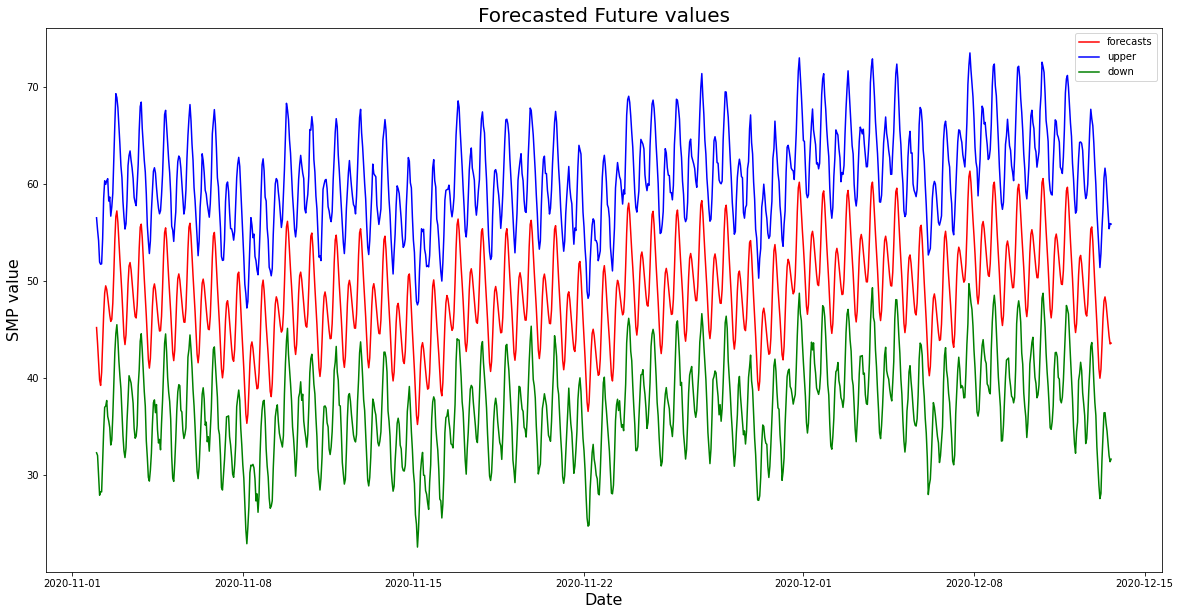

In [46]:
plt.plot(future_dataframe['ds'][-1000:],last_1000_hours, color='red')
plt.plot(future_dataframe['ds'][-1000:],last_1000_hours_upper, color='blue')
plt.plot(future_dataframe['ds'][-1000:],last_1000_hours_lower, color='green')
plt.rcParams["figure.figsize"] = (20,10)
plt.legend(['forecasts','upper','down'])

plt.title('Forecasted Future values', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('SMP value', fontsize=16)

In [47]:
from scipy import stats
stats.describe(last_1000_hours)

DescribeResult(nobs=1000, minmax=(35.2264944036852, 61.29598036725487), mean=48.7328778736595, variance=23.70000340176662, skewness=0.029580587533255043, kurtosis=-0.3192636579213053)

In [48]:
np.std(last_1000_hours)

4.865830185935885

--------